In [292]:
library(reshape2)
library(tibble)
library(igraph)
library(xtable)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)
# library(rgl)
library(pROC)

# library(pheatmap)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)
# library(repr)
# options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())

## Custom
source("../functions.R")

In [293]:
# FUNCTIONS ---------------------------------------------------------------
#' @param y_true numeric vector of true labels with 1 as positive
calc_recall <- function(y_true, y_pred) {
  sum(y_pred[y_true == 1] == 1) / sum(y_true == 1)
}
#' @param y_true numeric vector of true labels with 1 as positive
calc_specificity <- function(y_true, y_pred) {
  sum(y_pred[y_true == 0] == 0) / sum(y_true == 0)
} 

#' Sorts sample IDs so that they are paired
sort_sid <- function(x) {
  pid <- sapply(x, substring, 1, 4)
  time <- sapply(x, substring, 6, 7)
  time_pid <- mapply(paste0, time, pid)
  return(x[order(time_pid)])
}

#' Boolean function checking that dataframe provided has matching pair names
#' @param X dataframe with paired samples
#' @return logical indicating if it is paired or not
is_paired <- function(x) {
  #' @param character of sample ids
  #' @return logical indicating if it is paired or not
  .is_paired <- function(sid) {
    n <- length(sid)
    pid <- substring(sid, 1, 4)
    all(pid[1:(n / 2)] == pid[(n / 2 + 1):n])
  }
  
  if (is.data.frame(x) | is.matrix(x)) {
    return(.is_paired(colnames(x)))
  } else if (is.character(x)) {
    return(.is_paired(x))
  } else{
    stop("x is not a dataframe, matrix or character.")
  }
}

plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

## Import data

In [294]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [295]:
COL_LABEL <- c("darkolivegreen3", "tomato3")

Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

# List subtypes
subtypes9 <- levels(metadata_df$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [296]:
## Define train/test split
sid_mrd_na <- rownames(yeoh_label)[is.na(yeoh_label$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(Y)[
  !(Y$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_alltrain <- rownames(Y)[
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_train <- rownames(Y)[
  Y$batch_info %in% 1:7 &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_test <- rownames(Y)[
  Y$batch_info %in% 8:10 &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]

sid_remission <- rownames(Y)[Y$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Train/test split: Patients distribution

In [297]:
# TODO: Do not evaluate to heterogeneous subtypes
train_distr <- table(
  Y[sid_train, "subtype"],
  Y[sid_train, "label"]
)/2
test_distr <- table(
  Y[sid_test, "subtype"],
  Y[sid_test, "label"]
)/2

# # Transfer all relapse samples to test set
# test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# train_distr[, 2] <- 0

print(xtable(train_distr, display = rep("d", 3)))
print(xtable(test_distr, display = rep("d", 3)))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Tue Apr 20 16:08:09 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   4 &   5 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   7 &   1 \\ 
  TEL-AML1 &  20 &   4 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Tue Apr 20 16:08:09 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   1 &   0 \\ 
  E2A-PBX1 &   2 &   1 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   1 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   1 &   1 \\ 
  TEL-AML1 &   9 &   1 \\ 
   \hline
\end{tabular}
\end{table}


## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [298]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

#### Plot: UpSet

In [299]:
# list_batch_genes <- list(anova = batch_genes, welch = welch_genes,
#                          kruskal = kruskal_genes)

# upset(fromList(list_batch_genes),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-batch_genes.pdf",
#          width = 8, height = 8)

### Drug genes

Constant: Subtype, remission

In [300]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, sid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  if (!is_paired(X_subtype))
    stop("Patient IDs are not paired..")
  
  sid_idx <- intersect(sid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[, sid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission) / 2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  D0 <- X_subtype_remission[, 1:n_pairs, drop = F]
  D8 <- X_subtype_remission[, -(1:n_pairs), drop = F]
  
  # Median paired log-FC
  paired_logfc <- D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(D0)
  d8_mu <- rowMeans(D8)
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  feat <- intersect(feat_p, feat_log2fc)
  return(feat)
}

In [301]:
 #' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
compute_features <- function(
  response_df, normal_df,
  sid_train, sid_remission
) {
  print(rownames(response_df))
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n, , drop = F]
  d8_df <- response_df[-(1:n), , drop = F]
  
  if (!is_paired(t(response_df)))
    stop("Patient IDs are not paired..")
  
  # Calculate centroids
  # Only use remission patients in training set to calculate centroid
  sid_leuk <- Reduce(
    intersect,
    list(rownames(d0_df), sid_train, sid_remission)
  )
  print(rownames(d0_df))
  print(sprintf("NO. OF SAMPLES IN CENTROID: %d", length(sid_leuk)))
  leuk_centroid <- apply(d0_df[sid_leuk, , drop = F], 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)

}

In [302]:
#' ASSUMPTION: X_train is filtered of NA MRD values and contains all features!
#' @param X_train dataframe of training set (incl. MRD) with patients x features
#' @param Y dataframe of metadata with samples x info
#' @param bigpos_names vector of feature names where bigger is positive
#' @param smallpos_names vector of feature names where smaller is positive
#' @param X_test dataframe of test set (incl. MRD)
predict_plot <- function(X_train, Y,
                         bigpos_names,
                         smallpos_names,
                         X_test = NULL) {
  #' Calculate probability of remission as percentage of remission cases with
  #' scores that are worse than or equal to the current score
  #' @param X_train dataframe of training set (incl. MRD) with patients x features
  #' @param Y dataframe of metadata with samples x info
  #' @param bigpos_names vector of feature names where bigger is positive
  #' @param smallpos_names vector of feature names where smaller is positive
  #' @param X_predict dataframe containing samples to be predicted (incl. MRD)
  calc_p_remission <- function(X_train, Y,
                               bigpos_names,
                               smallpos_names,
                               X_predict) {
    #' Pct of remission cases with worse than or equal to the current score
    #' Bigger values indicate it being worse
    #' @param x vector of feature scores from diff samples
    #' @param x_remission vector of feature scores from relapse samples
    calc_pct_remission_x <- function(x, x_remission) {
      sapply(
        x,
        function(x_i) sum(x_i <= x_remission) / length(x_remission)
      )
    }
    
    #' Standardises features so that bigger values indicate positive label
    select_orientate_features <- function(X, bigpos_names, smallpos_names) {
      # Assumption: Either smallpos_names or bigpos_names will not be NULL
      if (is.null(smallpos_names)) {
        return(X[, bigpos_names, drop =  F])
      } else if (is.null(bigpos_names)) {
        # reverse order - bigger values now indicate relapse
        return(-X[, smallpos_names, drop =  F])
      } else {
        return(cbind(-X[, smallpos_names, drop =  F],
                     X[, bigpos_names, drop =  F]))
      }
    }

    X1_train <- select_orientate_features(X_train, bigpos_names, smallpos_names)
    idx <- paste0(rownames(X1_train), "_D0") # in order to access metadata
    Y1_train <- Y[idx, , drop = F]
    X1_train_remission <- X1_train[Y1_train$label == 0,]  # Only remission
    
    X1_predict <- select_orientate_features(X_predict, bigpos_names, smallpos_names)
    
    pct_remission <- mapply(calc_pct_remission_x,
                            data.frame(X1_predict),
                            data.frame(X1_train_remission),
                            SIMPLIFY = F)
    pct_remission <- data.frame(pct_remission)
    rownames(pct_remission) <- rownames(X1_predict)

    # Average p(remission|x)
    p <- apply(pct_remission, 1, mean, na.rm = T)
    p_wo <- apply(pct_remission, 1, mean, na.rm = T) # with no mrd
    
    label <- as.factor(
      Y[paste0(rownames(X1_predict), "_D0"), "label"]
    )
    
    p_remission <- data.frame(
      pid = rownames(pct_remission),
      label = label,
      p = p,
      p_wo = p_wo, # OPTION: DELETE WHEN PLOTTING
      pct_remission
    )
    
    return(p_remission)
  }
  
  # If test set is present, predict test set
  if (is.null(X_test)) {
    X_predict <- X_train
  } else {
    X_predict <- X_test
  }
  
  p_remission <- calc_p_remission(
    X_train, Y,
    bigpos_names,
    smallpos_names,
    X_predict
  )
  
  pred <- p_remission
  
  # Select features
  X_fltr_train <- X_train[, c(bigpos_names, smallpos_names)]
  X_fltr_predict <- X_predict[, c(bigpos_names, smallpos_names)]
  
  # Plot: Jitter - Features and risk_relapse
  X_y <- cbind(
    X_fltr_predict,
    p_rem = pred$p,
    label = pred$label
  )
  X_y$mrd <- log10(X_y$mrd) # log-transform  mrd
  colnames(X_y)[colnames(X_y) == "mrd"] <- "log_mrd"

  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
  
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_d0d8_d0normal", "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ')')"
  )
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  ) # Reorder levels
  
#   print(head(long_X_y))
#   print(levels(long_X_y$feature))
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    list_p_rem <- split(X_y$p_rem, X_y$label)
    
    try({
      ttest <- t.test(list_p_rem[[1]], list_p_rem[[2]])
      p_lab <- sprintf("p = %.3f", ttest$p.value)
      
      ann_text <- data.frame(
        feature = factor(
          FEAT_ORDER[5],
          levels = FEAT_ORDER,
          labels = FEAT_LABS
        ),
        value = Inf,
        lab =  p_lab
      )

      ax_jitter <- ax_jitter +
        geom_text(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  vjust = 3, hjust = -0.1)
      })
  }
  
  ## Plot: Parallel coordinates - Pct
  pred1 <- pred[, -which(colnames(pred) == "p_wo")]
  long_pred <- melt(pred1, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_pred,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: CDF
  emp_cdf <- ggplot(pred,
                    aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- pred[order(pred$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
  
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
  
  ## Plot: ROC
  # ERM1 evaluated is not from global GSS model
  pred_x <- cbind(pred, erm = X_predict$erm1, d33_mrd = X_predict$mrd) # subset mrd
                                
  x_names <- c("p", "erm", "d33_mrd")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (length(table(pred_x$label)) > 1) {
    ax_roc <- plot_roc(pred_x, "label", x_names)
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                 ncol = 2, rel_widths = c(1.8, 1))
  } else{
    ax2 <- ax_parallel # unable to plot ROC
  }
  
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(pred_x) +
    geom_point(aes(p, log10(d33_mrd), colour = label),
               cex = 3, show.legend = F) +
    scale_color_manual(values = COL_LABEL)
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)
  
  list(
    p_rem = pred[, "p", drop = F],
    P = pred,
    X_y = X_y,
    plot = fig
  )
}

In [303]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline <- function(X_subtype, X_normal,
                             metadata, metadata_mrd,
                             batch_genes = NULL) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  class_genes <- getLocalGenes(X_subtype, sid_remission)
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"]
  
  prediction_obj <- predict_plot(
    V, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(prediction_obj)
}

### M1: Entire data

In [304]:
X_normal <- data[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) data[,
    sid_alltrain_local[Y[sid_alltrain_local, "subtype"] == subtype]
  ]
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0"
[1] "NO. OF SAMPLES IN CENTROID: 5"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0" "P049_D8"
 [8] "P050_D8" "P051_D8" "P102_D8" "P145_D8" "P161_D8"
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0"
[1] "NO. OF SAMPLES IN CENTROID: 5"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 718"
[1] "No. of features (p-value) = 2508"
[1] "No. of features (log2-fc) = 283"
[1] "No. of selected genes = " "281"                     
[1] "No. of final genes = " "216"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P043_D0" "P044_D0"
 [8] "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0" "P129_D0"
[15] "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0" "P153_D0" "P154_D0"
[22] "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0" "P169_D0" "P176_D0"
[29] "P178_D0" "P182_D0" "P189_D0" "P195_D0" "P196_D0" "P207_D0" "P208_D0"
[36] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P043_D8" "P044_D8"
[43] "P046_D8" "P047_D8" "P048_D8" "P098_D8" "P100_D8" "P109_D8" "P129_D8"
[50] "P133_D8" "P138_D8" "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8"
[57] "P155_D8" "P157_D8" "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8"
[64] "P178_D8" "P182_D8" "P189_D8" "P195_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P160_D0" "P167_D0" "P211_D0"
 [8] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P160_D8" "P167_D8" "P211_D8"
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P160_D0" "P167_D0" "P211_D0"
[1] "NO. OF SAMPLES IN CENTROID: 3"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P097_D0" "P101_D0" "P104_D0" "P105_D0"
 [36] "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0" "P128_D0"
 [43] "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0" "P149_D0"
 [50] "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0" "P177_D0"
 [57] "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0" "P193_D0"
 [64] "P194_D0" "P197_D0" "P199_D0"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 998"
[1] "No. of features (p-value) = 606"
[1] "No. of features (log2-fc) = 342"
[1] "No. of selected genes = " "136"                     
[1] "No. of final genes = " "110"                  
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P103_D0" "P116_D0" "P151_D0" "P001_D8" "P004_D8" "P005_D8" "P007_D8"
[15] "P008_D8" "P010_D8" "P012_D8" "P103_D8" "P116_D8" "P151_D8"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P103_D0" "P116_D0" "P151_D0"
[1] "NO. OF SAMPLES IN CENTROID: 8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 710"
[1] "No. of features (p-value) = 2765"
[1] "No. of features (log2-fc) = 507"
[1] "No. of selected genes = " "505"                     
[1] "No. of final genes = " "371"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P127_D0" "P135_D0"
[29] "P136_D0" "P147_D0" "P156_D0" "P165_D0" "P166_D0" "P172_D0" "P013_D8"
[36] "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P022_D8"
[43] "P023_D8" "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8"
[50] "P031_D8" "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8"
[57] "P099_D8" "P106_D8" "P120_D8" "P121_D8" "P127_D8" "P135_D8" "P136_D8"
[64] "P147_D8" "P156_D8" "P165_D8" "P166_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


#### Consolidate p(remission|x)

In [310]:
names(list_obj1) <- subtypes7
list_obj2 <- list_obj1[subtypes5] # select homogeneous subtypes
names(list_obj2) <- NULL # avoid funny row.names
list_p2 <- lapply(list_obj2, function(obj) obj$p_rem)
m1_p_alltrain <- do.call(rbind, list_p2) 

In [311]:
write.table(m1_p_alltrain, "tmp/m1-p_alltrain.tsv", quote = F, sep = "\t")

#### Plot boxplots of features

In [259]:
#' Plots boxplot of features, p_rem WITHOUT global ERM
#' Provides p-values from wilcoxon rank-sum test
plot_boxplots <- function(X_y) {
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ')')"
  )
  
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")

  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(
      position = position_jitterdodge(),
      cex = 2, # pch = 21, colour = "black",
      show.legend = F
    ) +
    scale_colour_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    p_labs <- sapply(
      FEAT_ORDER,
      function(idx) {
        list_feat <- split(X_y[, idx], X_y$label)
        tryCatch(
          {
            htest <- wilcox.test(list_feat[[1]], list_feat[[2]])
            sprintf("p = %.3f", htest$p.value)
          },
          error = function(err) {
            print(err)
            return(err)
          }
        )
      }
    )
    
    ann_text <- data.frame(
      feature = factor(
        FEAT_ORDER,
        levels = FEAT_ORDER,
        labels = FEAT_LABS
      ),
      value = c(
        max(X_y[FEAT_ORDER[1]]),
        max(X_y[FEAT_ORDER[2]]),
        min(X_y[FEAT_ORDER[3]]),        
        min(X_y[FEAT_ORDER[4]]),
        max(X_y[FEAT_ORDER[5]])
      ),
      lab = p_labs
    )
    ann_text <- na.omit(ann_text)

    ax_jitter <- ax_jitter +
      geom_label(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  alpha = 0.5, hjust = 0)
  }
  
  ax_jitter
}

In [260]:
## M1: Entire data (with Hyperdiploid, Others)
list_feat_boxplots <- lapply(list_obj1, function(obj) plot_boxplots(obj$X_y))

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]]):
“cannot compute exact p-value wi

In [261]:
for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/temp/features_alltrain_wilcox-%s.pdf", subtypes7[i])
  ggsave(wpath, list_feat_boxplots[[i]],
         width = 10, height = 3)
}

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### M1: Train/test

In [307]:
#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
predict_pipeline_test <- function(
  sid_subtype, X_normal,
  metadata, metadata_mrd,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, X
) {  
  sid_subtype_train <- intersect(sid_subtype, sid_train)
  sid_subtype_test <- intersect(sid_subtype, sid_test)
  
  subtype_train <- X[, sid_train, drop = F]
  subtype_test <- X[, sid_test, drop = F]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(subtype_train, sid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X[selected_genes, sid_subtype, drop = F])
  normal <- t(X[selected_genes, sid_normal, drop = F])
  
  # Compute features on both train and test
  V <- compute_features(response, normal, sid_train, sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"] # append column
  
  print(sid_subtype_train)
  print(sid_subtype_test)
  if (!(is_paired(sid_subtype_train)))
    stop("sample ids are not paired")
  if (!(is_paired(sid_subtype_test)))
    stop("sample ids are not paired")
  
  pid_subtype_train <- unique(substring(sid_subtype_train, 1, 4))
  pid_subtype_test <- unique(substring(sid_subtype_test, 1, 4))
  
  V_train <- V[pid_subtype_train, , drop = F ]
  V_test <- V[pid_subtype_test, , drop = F ]
  
  obj_train <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  obj_test <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd"),
    V_test
  )
  
  list(train = obj_train, test = obj_test)
}

### M1: Test set 1 (w/o Hyp, Others)

In [312]:
list_subtypes5 <- lapply(
  subtypes5,
  function(subtype) sid_alltrain_local[
    Y[sid_alltrain_local, "subtype"] == subtype
  ]
)

list_m1_train_test <- lapply(
  list_subtypes5,
  predict_pipeline_test,
  X_normal, Y, yeoh_label,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, data
)

list_m1_train <- lapply(list_m1_train_test, function(obj) obj$train)
list_p_rem_train <- lapply(list_m1_train, function(obj) obj$p_rem)
m1_p_train <- do.call(rbind, list_p_rem_train)
                           
list_m1_test <- lapply(list_m1_train_test, function(obj) obj$test)
list_p_rem_test <- lapply(list_m1_test, function(obj) obj$p_rem)
m1_p_test <- do.call(rbind, list_p_rem_test)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0"
[1] "NO. OF SAMPLES IN CENTROID: 4"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8"
[15] "P134_D8" "P152_D8" "P170_D8" "P184_D8"
[1] "P175_D0" "P175_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0" "P049_D8"
 [8] "P050_D8" "P051_D8" "P102_D8" "P145_D8" "P161_D8"
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0"
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "P049_D0" "P050_D0" "P051_D0" "P049_D8" "P050_D8" "P051_D8"
[1] "P102_D0" "P145_D0" "P161_D0" "P102_D8" "P145_D8" "P161_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P160_D0" "P167_D0" "P211_D0"
 [8] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P160_D8" "P167_D8" "P211_D8"
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P160_D0" "P167_D0" "P211_D0"
[1] "NO. OF SAMPLES IN CENTROID: 2"
[1] "P058_D0" "P122_D0" "P160_D0" "P167_D0" "P058_D8" "P122_D8" "P160_D8"
[8] "P167_D8"
[1] "P131_D0" "P137_D0" "P211_D0" "P131_D8" "P137_D8" "P211_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P103_D0" "P116_D0" "P151_D0" "P001_D8" "P004_D8" "P005_D8" "P007_D8"
[15] "P008_D8" "P010_D8" "P012_D8" "P103_D8" "P116_D8" "P151_D8"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P103_D0" "P116_D0" "P151_D0"
[1] "NO. OF SAMPLES IN CENTROID: 7"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P116_D0" "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P010_D8"
[15] "P012_D8" "P116_D8"
[1] "P103_D0" "P151_D0" "P103_D8" "P151_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P127_D0" "P135_D0"
[29] "P136_D0" "P147_D0" "P156_D0" "P165_D0" "P166_D0" "P172_D0" "P013_D8"
[36] "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P022_D8"
[43] "P023_D8" "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8"
[50] "P031_D8" "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8"
[57] "P099_D8" "P106_D8" "P120_D8" "P121_D8" "P127_D8" "P135_D8" "P136_D8"
[64] "P147_D8" "P156_D8" "P165_D8" "P166_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [313]:
write.table(m1_p_train, "tmp/m1-p_train.tsv", quote = F, sep = "\t")
write.table(m1_p_test, "tmp/m1-p_test.tsv", quote = F, sep = "\t")

### Yeoh (2018): Global ERM
- Feature selection: Top 1000 DE probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)
- Quantile normalisation does not improve results by much

#### All train (w/o Hyper, Others)

In [25]:
## Feature selection
excl_subtypes <- c("Hypodiploid", "Normal",
                   "Hyperdiploid", "Others")
sid_all <- rownames(Y)[!(Y$subtype %in% excl_subtypes)]
X <- data[, sid_all]
n <- ncol(X)
D0 <- X[, 1:(n / 2)]
D8 <- X[, (n / 2 + 1):n]

if (!is_paired(cbind(D0, D8)))
  stop("Patient IDs are not paired..")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(cbind(D0, D8)[ps_wilcox, ])
normal <- t(data[ps_wilcox, 403:405])
V <- compute_features(response, normal)
global_erm_alltrain <- V[, "erm1", drop = F]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


### Global ERM: Test data 2 (wo Hyper, Others)

In [251]:
X_train <- data[, sid_train4]
n <- ncol(X_train)
D0_train <- X_train[, 1:(n / 2)]
D8_train <- X_train[, (n / 2 + 1):n]

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

if (!is_paired(cbind(D0_train, D8_train)))
  stop("Patient IDs are not paired..")
## Feature selection (on training set only) without hyperdiploid, others!
wilcox_pvalue <- row_wilcox(D0_train, D8_train)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

# Subsetting features
response <- t(data[
  ps_wilcox, sort_sid(union(sid_train4, sid_test4))
])
normal <- t(data[ps_wilcox, 403:405])

V <- compute_features(response, normal)
global_erm_train <- V[
  unique(substring(sid_train4, 1, 4)), # subset train samples
  "erm1", drop = F
]
global_erm_test <- V[
  unique(substring(sid_test4, 1, 4)), # subset test samples
  "erm1", drop = F
]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


## Plot: ROC

In [175]:
#' Plots ROC curve
#' @import ggplot2
#' @param X dataframe containing scores / predictions and labels
#' @param response character containing name of column in X with labels
#' @param predictor character containing name of column/s in X of predictors
#' @param direction character belonging to c("auto", "<", ">"). control < case
#' no character vectors allowed to specific multiple different directions!
#' @param pauc.limits numeric vector of length 2 indicating limits
plot_roc <- function(
  X, response, predictor,
  direction = "auto",
  pauc.limits = FALSE,
  pauc.axis = c("specificity", "sensitivity"),
  pauc.correct = TRUE,
  plot.labels = NULL,
  return.auc = FALSE,
  lwd = 1
) {
  pauc.axis = match.arg(pauc.axis)
  
  auc_caption <- "AUC"
  if (!is.logical(pauc.limits)) {
    # If pAUC limits are provided
    pauc.limits <- sort(pauc.limits, decreasing = TRUE)
    auc_caption <- "pAUC"
  }
  
  if (length(predictor) == 1) {
    # Single ROC curve
    roc_objs <- roc(
      X[[response]],
      X[[predictor]],
      direction = direction,
      partial.auc = pauc.limits,
      partial.auc.focus = pauc.axis,
      partial.auc.correct = pauc.correct
    )
    aucs <- roc_objs$auc
    d <- data.frame(
      FPR = 1 - roc_objs$specificities,
      TPR = roc_objs$sensitivities
    )
    d <- d[nrow(d):1, ]
    d <- cbind(names = predictor, d)
  } else if (length(predictor) > 1) {
    # To ensure that direction can be subsetted
    if (length(direction) == 1) {
      direction <- rep(direction, length(predictor))
    } else if (length(predictor) != length(direction)) {
      stop("Length of direction not equals to that of predictor!")
    }
    
    roc_objs <- lapply(
      seq_along(predictor),
      function(i) {
        roc(
          X[[response]],
          X[[predictor[i]]],
          direction = direction[i],
          partial.auc = pauc.limits,
          partial.auc.focus = pauc.axis,
          partial.auc.correct = pauc.correct
        )
      }
    )
    aucs <- sapply(roc_objs, function(obj) obj$auc)
    list_d <- lapply(
      roc_objs,
      function(obj) data.frame(
        FPR = 1 - obj$specificities,
        TPR = obj$sensitivities
      )
    )
    list_d <- lapply(list_d, function(d) d[nrow(d):1, ])
    d <- do.call(rbind, list_d)
    n_rows <- sapply(list_d, nrow)
    predictors_col <- rep(predictor, n_rows)
    d <- cbind(names = predictors_col, d)
  } else {
    stop("arg predictor is of non-positive length.")
  }
  
  print(str(roc_objs))
  
  if (!(is.null(plot.labels))) {
    if (length(predictor) != length(plot.labels)) {
      stop("length of plot labels does not match number of predictors!")
    }
    # Order according to lexical order of predictor
    labels <- sprintf("%s (%s: %.3f)", plot.labels, auc_caption, aucs)
    labels[is.na(aucs)] <- plot.labels[is.na(aucs)]
    labels <- labels[order(predictor)]
  } else {
    # Order according to lexical order of predictor
    labels <- sort(sprintf("%s (%s: %.3f)", predictor, auc_caption, aucs))
    labels[is.na(aucs)] <- predictor[is.na(aucs)]
  }
  
  ax_roc <- ggplot() +
    geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1),
                 inherit.aes = FALSE,
                 lty = "dotted", lwd = lwd,
                 colour = "black", alpha = .4) +
    geom_line(data = d,  # to avoid mutiple plotting of geom_segment
              aes(x = FPR, y = TPR, col = names),  # OPTION lty = names
              direction = "hv", lwd = lwd) +
    scale_color_discrete(
      name = element_blank(),
      label = labels
    ) +
#     scale_linetype_discrete(
#       name = element_blank(),
#       label = labels
#     ) +
    theme_bw() +
    labs(x = "FPR", y = "TPR") +
    theme(
      legend.position = c(.95, .05),
      legend.justification = c("right", "bottom"),
      legend.background = element_rect(fill = NA)
    )
  
  if (is.logical(pauc.limits)) {
    # if no pauc.limits is provided
    ax_roc <- ax_roc +
      coord_cartesian(xlim = c(0, 1)) +
      coord_cartesian(ylim = c(0, 1))
  } else if (pauc.axis == "specificity") {
    fpr_limits <- 1 - pauc.limits
    d_rect <- data.frame(
      xmin = fpr_limits[1], xmax = fpr_limits[2],
      ymin = 0, ymax = 1
    )
    ax_roc <- ax_roc +
#       coord_cartesian(xlim = fpr_limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  } else if (pauc.axis == "sensitivity") {
    d_rect <- data.frame(
      xmin = 0, xmax = 1,
      ymin = pauc.limits[2], ymax = pauc.limits[1]
    )
    ax_roc <- ax_roc +
#       coord_cartesian(ylim = pauc.limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  }
  
  if (return.auc) {
    return(list(plot = ax_roc, auc = aucs))
  }
  ax_roc
}

In [303]:
#' @param p dataframe of predictions from model M1
#' @param global_erm
combine_save_roc <- function(
  p, global_erm, bhoj, kang, pid_annot, wpath = NULL
) {
  eval_test <- data.frame(
    p,
    global_erm = global_erm[rownames(p), ],
    bhoj = bhoj[rownames(p)],
    kang = kang[rownames(p)],
    mrd = pid_annot[rownames(p), "d33_mrd"],
    label = pid_annot[rownames(p), "label"]
  )
  x_names <- c("M1", "ERM", "BHOJ", "KANG", "MRD")
  colnames(eval_test) <- c(x_names, "label")
#   print(eval_test)
  legend_labs <- c(
    "SSM", "Global ERM", "Bhojwani et al. [2008]",
    "Kang et al. [2010]", "Day 33 MRD"
  )
  
  ax_roc <- plot_roc(
    eval_test,
    "label", x_names,
    direction = c(">", ">", "<", "<", "<"),
    pauc.limits = c(1, .8),
    plot.labels = legend_labs
  )
  
  if (!is.null(wpath)) {
    ggsave(wpath, ax_roc, width = 5, height = 5)
  }
  return(ax_roc)
}

### Train/test split (w/o Hyperdiploid, Others)

#### Train split

In [305]:
WPATH <- "~/Dropbox/temp/roc-train.pdf"
eval_train2 <- combine_save_roc(
  m1_p_train,
  global_erm_train, # Global ERM model built using all subtypes
  bhoj_y_train,
  kang_y_train,
  yeoh_label,
  WPATH
)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 5
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:38] 1 1 1 1 1 ...
  ..$ specificities     : num [1:38] 0 0.0278 0.1111 0.1389 0.1667 ...
  ..$ thresholds        : num [1:38] Inf 0.906 0.866 0.854 0.836 ...
  ..$ direction         : chr ">"
  ..$ cases             : num [1:12] 0.812 0.25 0.312 0.5 0.25 ...
  ..$ controls          : num [1:36] 0.438 0.562 0.688 0.875 0.583 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.778
  .. ..- attr(*, "partial.auc")= num [1:2] 1 0.8
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:38] 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:38] 0 0.0278 0.1111 0.1389 0.1667 ...
  .. .. ..$ thresholds        : num [1:38] Inf 0.906 0.866 0.854 0.836 ...
  .. .. ..$ direction         : chr ">"
  .. .. ..$ cases             : num [1:1

Warning message:
“Ignoring unknown parameters: direction”

#### Test split

In [304]:
WPATH <- "~/Dropbox/temp/roc-test.pdf"
eval_test2 <- combine_save_roc(
  m1_p_test,
  global_erm_test, # Global ERM model built using all subtypes
  bhoj_y_test,
  kang_y_test,
  yeoh_label,
  WPATH
)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1


List of 5
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:16] 1 1 1 1 1 1 1 1 1 0.8 ...
  ..$ specificities     : num [1:16] 0 0.0714 0.1429 0.2857 0.3571 ...
  ..$ thresholds        : num [1:16] Inf 0.925 0.881 0.837 0.819 ...
  ..$ direction         : chr ">"
  ..$ cases             : num [1:5] 0.167 0.25 0.125 0.25 0.55
  ..$ controls          : num [1:14] 0.312 0.167 0.333 0.75 0.393 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.79
  .. ..- attr(*, "partial.auc")= num [1:2] 1 0.8
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:16] 1 1 1 1 1 1 1 1 1 0.8 ...
  .. .. ..$ specificities     : num [1:16] 0 0.0714 0.1429 0.2857 0.3571 ...
  .. .. ..$ thresholds        : num [1:16] Inf 0.925 0.881 0.837 0.819 ...
  .. .. ..$ direction         : chr ">"
  .. .. ..$ cases     

Warning message:
“Ignoring unknown parameters: direction”

### All train (w/o Hyperdiploid, Others)

In [320]:
WPATH <- "~/Dropbox/temp/roc-alltrain.pdf"
roc_alltrain <- combine_save_roc(
  p_alltrain,
  global_erm_alltrain, # Global ERM model built using all subtypes
  bhoj_y_alltrain,
  kang_y_alltrain,
  yeoh_label,
  WPATH
)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 5
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:50] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:50] 0 0.02 0.04 0.06 0.08 0.12 0.14 0.16 0.18 0.2 ...
  ..$ thresholds        : num [1:50] Inf 0.945 0.939 0.919 0.894 ...
  ..$ direction         : chr ">"
  ..$ cases             : num [1:17] 0.35 0.25 0.25 0.35 0.25 ...
  ..$ controls          : num [1:50] 0.65 0.95 0.3 0.8 0.45 0.5 0.75 0.65 0.5 0.9 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.858
  .. ..- attr(*, "partial.auc")= num [1:2] 1 0.8
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:50] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:50] 0 0.02 0.04 0.06 0.08 0.12 0.14 0.16 0.18 0.2 ...
  .. .. ..$ thresholds        : num [1:50] Inf 0.945 0.939 0.919 0.894 ...
  .. .. ..$ di

Warning message:
“Ignoring unknown parameters: direction”

## Plot: M1 consolidated predictions

#### All train set

In [44]:
p_alltrain_concat <- cbind(
  p_alltrain,
  subtype = yeoh_label[rownames(p_alltrain), "subtype"],
  label = factor(
    yeoh_label[rownames(p_alltrain), "label"],
    labels = c("Long-term remission", "Relapse")
  ),
  log_mrd = log10(yeoh_label[rownames(p_alltrain), "d33_mrd"]),
  erm = global_erm_alltrain[rownames(p_alltrain), ]
)

# Plot: Scatter
p_mrd_alltrain <- ggplot(
  p_alltrain_concat,
  aes(x = p, y = log_mrd, colour = subtype, pch = label)
) +
  geom_point(size = 2) +
  labs(
    colour = "Subtype",
    pch = "Outcome",
    x = expression(paste('P(Remission|', bold(x), ')')),
    y = expression(log[10](MRD))
  )

# WPATH <- "~/Dropbox/temp/mrd_p-alltrain.pdf"
# ggsave(WPATH, p_train_mrd, width = 6, height = 4)

p_erm_alltrain<- ggplot(
  p_alltrain_concat,
  aes(x = p, y = erm, colour = subtype, pch = label)
) +
  geom_point(size = 2)

In [45]:
labeller = label_parsedp_train_concat <- cbind(
  p_alltrain,
  subtype = yeoh_label[rownames(p_alltrain), "subtype"],
  label = factor(
    yeoh_label[rownames(p_alltrain), "label"],
    labels = c("Long-term remission", "Relapse")
  )
)

# Plot: Jitter - P v.s. Outcome
jitter_m1_alltrain <- ggplot(
    p_alltrain_concat,
    aes(x = label, y = p, colour = subtype)
  ) +
  geom_point(
    position = position_jitterdodge(
      jitter.width = .7,
      dodge.width = .7
    )
  ) +
  labs(
    colour = "Subtype",
    y = expression(paste('P(Remission|', bold(x), ')'))
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  )

In [85]:
# WPATH <- "~/Dropbox/temp/jitter-m1_alltrain.pdf"
# ggsave(WPATH, jitter_m1_alltrain, width = 4.5, height = 3)

#### Test set

In [91]:
p_test_concat <- cbind(
  p_test2,
  subtype = yeoh_label[rownames(p_test2), "subtype"],
  label = factor(
    yeoh_label[rownames(p_test2), "label"],
    labels = c("Long-term remission", "Relapse")
  )
)

# Plot: Jitter - P v.s. Outcome
jitter_m1_test <- ggplot(
    p_test_concat,
    aes(x = label, y = p, colour = subtype)
  ) +
  geom_point(
    position = position_jitterdodge(
      jitter.width = .6,
      dodge.width = .6
    )
  ) +
  labs(
    colour = "Subtype",
    y = expression(paste('P(Remission|', bold(x), ')'))
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  )

In [92]:
# WPATH <- "~/Dropbox/temp/jitter-m1_test.pdf"
# ggsave(WPATH, jitter_m1_test, width = 4.5, height = 3)

In [31]:
# False omission rate
PN <- sum(p_alltrain_concat$log_mrd <= -4)
FN <- sum(p_alltrain_concat$label[p_alltrain_concat$log_mrd <= -4] == "Relapse")
print(FN/PN)
print(FN)

[1] 0.1052632
[1] 4


## Survival analysis

In [8]:
library(survival)

SURV_RPATH <- "data/GSE67684/processed/metadata/pid-mrd_label_efs_subtype.tsv"
surv_annot <- read.table(SURV_RPATH, sep = "\t")

In [94]:
# Remove patients with NA MRD
surv_annot1 <- na.omit(surv_annot)
surv_annot1$d33_mrd_risk <- droplevels(surv_annot1$d33_mrd_risk)
# Reverse levels
surv_annot1$d33_mrd_risk <- factor(
  surv_annot1$d33_mrd_risk,
  levels = rev(levels(surv_annot1$d33_mrd_risk))
)

### Train set

In [97]:
### Subset alltrain set
surv_alltrain <- surv_annot1[rownames(p_alltrain), ]
# Discretise p(remission|x)
p_alltrain_cat <- character(nrow(p_alltrain_concat))
p_alltrain_cat[p_alltrain_concat$p > 0.5] <- "SR"
p_alltrain_cat[p_alltrain_concat$p <= 0.5] <- "IR"
p_alltrain_cat[p_alltrain_concat$p <= 0.25] <- "HR"
p_alltrain_cat <- as.factor(p_alltrain_cat)
# Reverse levels
p_alltrain_cat1 <- factor(p_alltrain_cat, levels = rev(levels(p_alltrain_cat)))
names(p_alltrain_cat1) <- rownames(p_alltrain_concat)
print(p_alltrain_cat1)

surv_alltrain1 <- cbind(surv_alltrain, ssm_risk = p_alltrain_cat1)
head(surv_alltrain1)

P053 P054 P055 P056 P057 P134 P152 P170 P175 P184 P049 P050 P051 P102 P145 P161 
  SR   SR   IR   IR   HR   HR   IR   SR   IR   HR   IR   SR   SR   HR   IR   SR 
P058 P122 P131 P137 P160 P167 P211 P001 P004 P005 P007 P008 P010 P012 P103 P116 
  SR   HR   HR   HR   SR   HR   SR   SR   SR   SR   HR   SR   HR   IR   IR   IR 
P151 P013 P014 P015 P016 P017 P018 P019 P022 P023 P024 P025 P026 P027 P028 P029 
  HR   SR   SR   IR   IR   SR   IR   IR   IR   IR   IR   SR   IR   SR   IR   IR 
P031 P032 P033 P034 P035 P036 P094 P099 P106 P120 P121 P127 P135 P136 P147 P156 
  SR   IR   SR   IR   SR   IR   HR   SR   SR   SR   SR   SR   SR   IR   SR   SR 
P165 P166 P172 
  SR   SR   SR 
Levels: SR IR HR


,d33_mrd,d33_mrd_risk,Status,event_code,label,years,training_test,subtype,ssm_risk
,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>
P053,1e-04,Standard,"BMT, CCR",0,0,8.871,Training set,BCR-ABL,SR
P054,7e-03,Intermediate,CCR,0,0,8.392,Training set,BCR-ABL,SR
P055,1e-04,Standard,"BMT, CCR",0,0,7.696,Training set,BCR-ABL,IR
P056,7e-04,Intermediate,Relapse,1,1,3.524,Training set,BCR-ABL,IR
P057,1e+00,High,"Relapse (Induction), BMT, Death",1,1,0.003,Training set,BCR-ABL,HR
P134,9e-02,High,"Relapse (Induction), 1st Relapse, 2nd Relapse, Death",1,1,0.003,Training set,BCR-ABL,HR


#### Kaplan-Meier model: SSM

In [100]:
km_alltrain_ssm <- survfit(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_alltrain1
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_alltrain-ssm.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend = c(
    "SSM Standard Risk",
    "SSM Intermediate Risk",
    "SSM High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [101]:
# 5 year EFS
summary(km_alltrain_ssm, times = 5)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_alltrain1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ ssm_risk, data = surv_alltrain1)

                ssm_risk=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           5           20            0            1            0            1 
upper 95% CI 
           1 

                ssm_risk=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000      12.0000       6.0000       0.7337       0.0935       0.5715 
upper 95% CI 
      0.9419 

                ssm_risk=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000       1.0000      11.0000       0.0833       0.0798       0.0128 
upper 95% CI 
      0.5442 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ ssm_risk, data = surv_alltrain1)

             N Observed Expected (O-E)^2/E (O-E)^2/V
ssm_risk=SR 32        0     9.10  9.10e+00  19.91658
ssm_risk=IR 23        6     6.07  8.58e-04   0.00135
ssm_risk=HR 12       11     1.83  4.59e+01  53.74846

 Chisq= 57.4  on 2 degrees of freedom, p= 3e-13 

#### Kaplan-Meier model: MRD

In [102]:
km_alltrain_mrd <- survfit(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain1
)
# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_alltrain-mrd.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend=c(
    "MRD Standard Risk",
    "MRD Intermediate Risk",
    "MRD High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [725]:
# 5 year EFS
summary(km_alltrain_mrd, times = 5)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain)

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000      23.0000       4.0000       0.8917       0.0512       0.7969 
upper 95% CI 
      0.9979 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        7.000        5.000        0.680        0.122        0.479 
upper 95% CI 
       0.965 

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        3.000        8.000        0.333        0.136        0.150 
upper 95% CI 
       0.742 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=Standard     38        4    10.43    3.9633    10.417
d33_mrd_risk=Intermediate 17        5     4.43    0.0738     0.101
d33_mrd_risk=High         12        8     2.14   16.0115    18.798

 Chisq= 20.6  on 2 degrees of freedom, p= 3e-05 

### Test set

In [85]:
# Subset test set
surv_test <- surv_annot1[rownames(p_test), ]
# Discretise p(remission|x)
p_test_cat <- character(nrow(p_test))
p_test_cat[p_test > 0.5] <- "SR"
p_test_cat[p_test <= 0.5] <- "IR"
p_test_cat[p_test <= 0.25] <- "HR"
p_test_cat <- as.factor(p_test_cat)
names(p_test_cat) <- rownames(p_test)
# Reverse levels
p_test_cat1 <- factor(p_test_cat, levels = rev(levels(p_test_cat)))
print(p_test_cat1)
surv_test1 <- cbind(surv_test, ssm_risk = p_test_cat1)
head(surv_test1)

P175 P102 P145 P161 P131 P137 P211 P103 P151 P099 P106 P120 P121 P127 P135 P136 
  IR   HR   HR   IR   HR   HR   SR   IR   HR   SR   SR   SR   SR   SR   SR   SR 
P147 P156 P166 
  SR   SR   SR 
Levels: SR IR HR


,d33_mrd,d33_mrd_risk,Status,event_code,label,years,training_test,subtype,ssm_risk
,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>
P175,1e-04,Standard,"BMT, CCR",0,0,3.929,Test set,BCR-ABL,IR
P102,2e-02,High,Relapse,1,1,1.353,Training set,E2A-PBX1,HR
P145,1e-04,Standard,CCR,0,0,3.855,Test set,E2A-PBX1,HR
P161,1e-04,Standard,CCR,0,0,5.949,Test set,E2A-PBX1,IR
P131,1e-02,High,Relapse,1,1,1.681,Training set,MLL,HR
P137,3e-04,Intermediate,Relapse,1,1,1.804,Training set,MLL,HR


#### Kaplan-Meier model: SSM

In [82]:
# EFS - 0 v.s. 1 & 2
km_test_ssm <- survfit(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_test1
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_test-ssm.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_test_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend = c(
    "SSM Standard Risk",
    "SSM Intermediate Risk",
    "SSM High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [886]:
# 5 year EFS
summary(km_test_ssm, times = 3)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_test1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

                p_cat3=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       7.0000       1.0000       0.9091       0.0867       0.7541 
upper 95% CI 
      1.0000 

                p_cat3=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           3            3            0            1            0            1 
upper 95% CI 
           1 

                p_cat3=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       4.0000       0.2000       0.1789       0.0346 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

           N Observed Expected (O-E)^2/E (O-E)^2/V
p_cat3=SR 11        1    2.995     1.329      3.33
p_cat3=IR  3        0    0.926     0.926      1.14
p_cat3=HR  5        4    1.078     7.917     10.20

 Chisq= 10.3  on 2 degrees of freedom, p= 0.006 

#### Kaplan-Meier model: MRD

In [83]:
# EFS - 0 v.s. 1 & 2
km_test_mrd <- survfit(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_test1
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_test-mrd.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_test_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend=c(
    "MRD Standard Risk",
    "MRD Intermediate risk",
    "MRD High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [103]:
# 5 year EFS
summary(km_test_mrd, times = 3)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_test1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       9.0000       1.0000       0.9167       0.0798       0.7729 
upper 95% CI 
      1.0000 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       3.000        1.000        1.000        0.667        0.272        0.300 
upper 95% CI 
       1.000 

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       3.0000       0.2500       0.2165       0.0458 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=Standard     12        1    3.304   1.60684   4.75922
d33_mrd_risk=Intermediate  3        1    0.926   0.00586   0.00721
d33_mrd_risk=High          4        3    0.769   6.46605   7.78223

 Chisq= 8.2  on 2 degrees of freedom, p= 0.02 

#### Kaplan-Meier: Stratify by MRD

In [91]:
# # Stratify into separate MRD categories and plot KM
# idx_hr <- surv_test1$d33_mrd_risk != "Standard"
# surv_hr <- surv_test1[idx_hr, ]
# surv_sr <- surv_test1[!idx_hr, ]

# km_hr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_hr 
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_hr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

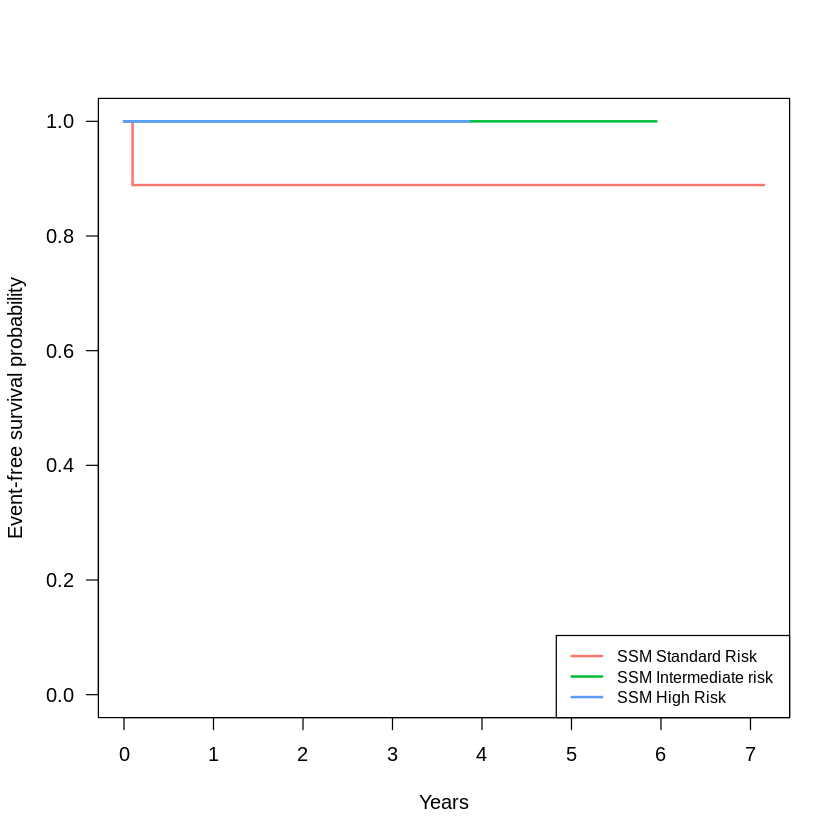

In [90]:
# km_sr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_sr
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_sr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

### Cox PH model
- Coefficients and HRs are extremely large
- Due to standard risk having no events at all

In [93]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ p_cat1,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [92]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ d33_mrd_risk,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [701]:
# # Check: Linearity assumption
# plot(predict(multi_cox), residuals(multi_cox, type = "martingale"))
# lines(smooth.spline(predict(multi_cox),
#                     residuals(multi_cox, type = "deviance")))

# # Check: Proportional hazards assumption
# plot(cox.zph(multi_cox)[1])

In [688]:
# Multivariate Fine and Gray
# Adjust for subtype, NCI risk criteria
# bmtcrrMat <- model.matrix(object = ~ D + Age + Sex + Phase + Source, data = bmtcrr)

# bmtcrrMat <- bmtcrrMat[,-1]
# head(bmtcrrMat)
# resCrrRel <- crr(ftime    = bmtcrr$ftime, # vector of failure/censoring times
#                  fstatus  = bmtcrr$Status, # vector with a unique code for each failure type and censoring
#                  cov1     = bmtcrrMat, #  matrix (nobs x ncovs) of fixed covariates
#                  ## cov2     = , # matrix of covariates that will be multiplied by functions of time
#                  ## tf       = , # functions of time
#                  ## cengroup = , # vector with different values for each group with a distinct censoring distribution
#                  failcode = "Relapse", # code of fstatus that denotes the failure type of interest
#                  cencode  = "Censored" # code of fstatus that denotes censored observations
#                  )
# summary(resCrrRel)

## Other methods

### Kang et al. (2010)

In [105]:
log_scaled_data <- log2_transform(scaled_yeoh)
KANG_RPATH <- "data/other_methods/kang_2010-ps.txt"
kang_ps <- readLines(con = KANG_RPATH)

kang_idx <- kang_ps[kang_ps %in% rownames(raw_yeoh)] # 26 probesets
# Select probesets
data_kang <- log_scaled_data[kang_idx, ]

#### All train

In [244]:
# Subset n = 67 patients
d0_kang <- data_kang[, Y[colnames(data_kang), "class_info"] == "D0"]
colnames(d0_kang) <- substring(colnames(d0_kang), 1, 4)
kang_sub <- d0_kang[, rownames(p_train2)]

# PCA
d0_kang_pca <- prcomp(t(kang_sub), center = T, scale. = T)$x
# Survival data
surv_kang <- surv_annot[
  rownames(p_train2),
  c("event_code", "years")
]
kang_alltrain <- cbind(surv_kang, PC1 = d0_kang_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = kang_alltrain
)

# i.e. surv_kang$PC1 * -0.20986
kang_y_alltrain <- predict(cox_kang, newdata = kang_alltrain, type = "lp")
print(head(kang_y_alltrain))

       P053        P054        P055        P056        P057        P134 
 0.08157776  0.06334049 -0.02298371  0.10857688  0.15209160  0.15141408 


In [ ]:
# pdf("~/Dropbox/temp/kang_2010-risk_alltrain.pdf", width = 4, height = 5)
# plot(
#   surv_annot[rownames(p_train2), "label"],
#   kang_risk,
#   xlab = "Outcome", ylab = "Risk score"
# )
# dev.off()

In [233]:
# surv_kang1 <- cbind(surv_kang, risk = kang_risk)

# km_kang <- survfit(
#   Surv(years, event_code != 0) ~ risk > 0,
#   data = surv_kang1
# )


# # COL <- ggplot_palette(3)
# plot(
#   km_kang, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "MRD Standard Risk",
#     "MRD Intermediate risk",
#     "MRD High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

#### Test set

In [245]:
pid_train4 <- unique(substring(sid_train4, 1, 4))
pid_test4 <- unique(substring(sid_test4, 1, 4))

kang_train <- d0_kang[, pid_train4]
kang_test <- d0_kang[, pid_test4]

# PCA
kang_train_pca_obj <- prcomp(t(kang_train), center = T, scale. = T)
kang_train_pca <- kang_train_pca_obj$x
# Survival data
surv_kang <- surv_annot[
  pid_train4,
  c("event_code", "years")
]
kang_train <- cbind(surv_kang, PC1 = kang_train_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = kang_train
)
# Train set predictions
kang_y_train <- predict(cox_kang, newdata = kang_train, type = "lp")

# PCA (project)
kang_test_pca <- predict(kang_train_pca_obj, newdata = t(kang_test))
kang_y_test <- predict(
  cox_kang, newdata = data.frame(kang_test_pca[, 1, drop = F]), type = "lp"
)

### Bhojwani et al. (2009)
- LP1 is the model evaluated to be the best by the authors

In [181]:
log_scaled_data <- log2_transform(scaled_yeoh)
BHOJ_RPATH <- "data/other_methods/bhojwani_2008-full.txt"
bhoj_ps <- readLines(con = BHOJ_RPATH)

In [183]:
bhoj_ps1 <- c(
  "201472_at",
  "208687_x_at",
  "212576_at"
)
bhoj_ps2 <- c(
  "200641_s_at",
  "201472_at",
  "205401_at",
  "208820_at",
  "212576_at"
)
bhoj_ps3 <- c(
  "200641_s_at",
  "201472_at",
  "208820_at",
  "212576_at"
)

bhoj_idx0 <- bhoj_ps[bhoj_ps %in% rownames(raw_yeoh)]
bhoj_idx1 <- bhoj_ps1[bhoj_ps1 %in% rownames(raw_yeoh)]
bhoj_idx2 <- bhoj_ps2[bhoj_ps2 %in% rownames(raw_yeoh)]
bhoj_idx3 <- bhoj_ps3[bhoj_ps3 %in% rownames(raw_yeoh)]

#### All train set

In [217]:
# Subset n = 67 patients
sid_alltrain <- paste0(rownames(p_train2), "_D0")
d0_alltrain <- log_scaled_data[, sid_alltrain]
colnames(d0_alltrain) <- substring(colnames(d0_alltrain), 1, 4)
bhoj_lab <- as.factor(surv_annot[rownames(p_train2), "label"])

In [218]:
# Select probesets
predict_lr <- function(ps) {
  data_bhoj <- d0_alltrain[ps, ]
  Xy_bhoj <- data.frame(t(data_bhoj), label = bhoj_lab)
  bhoj_model <- glm(
    label ~ ., data = Xy_bhoj,
    family = binomial(link = "logit"),
    maxit = 500
  )
  predict(bhoj_model, newdata = Xy_bhoj)  
}

In [223]:
# LP1
bhoj_y_alltrain <- predict_lr(bhoj_idx1)
print(head(bhoj_y_alltrain))

      P053       P054       P055       P056       P057       P134 
-0.7656011 -2.7634169 -0.6048632 -0.8339909 -1.4765924 -0.4432948 


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 4
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:68] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:68] 0 0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 ...
  ..$ thresholds        : num [1:68] -Inf -172.4 -139.6 -109 -95.5 ...
  ..$ direction         : chr "<"
  ..$ cases             : num [1:17] 26.1 124.2 25.5 26.8 119.1 ...
  ..$ controls          : num [1:50] -48.1 -66.8 -25 -54.3 -25.8 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 1
  .. ..- attr(*, "partial.auc")= logi FALSE
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:68] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:68] 0 0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 ...
  .. .. ..$ thresholds        : num [1:68] -Inf -172.4 -139.6 -109 -95.5 ...
  .. .. ..$ direction         : ch

Warning message:
“Ignoring unknown parameters: direction”Coordinate system already present. Adding new coordinate system, which will replace the existing one.


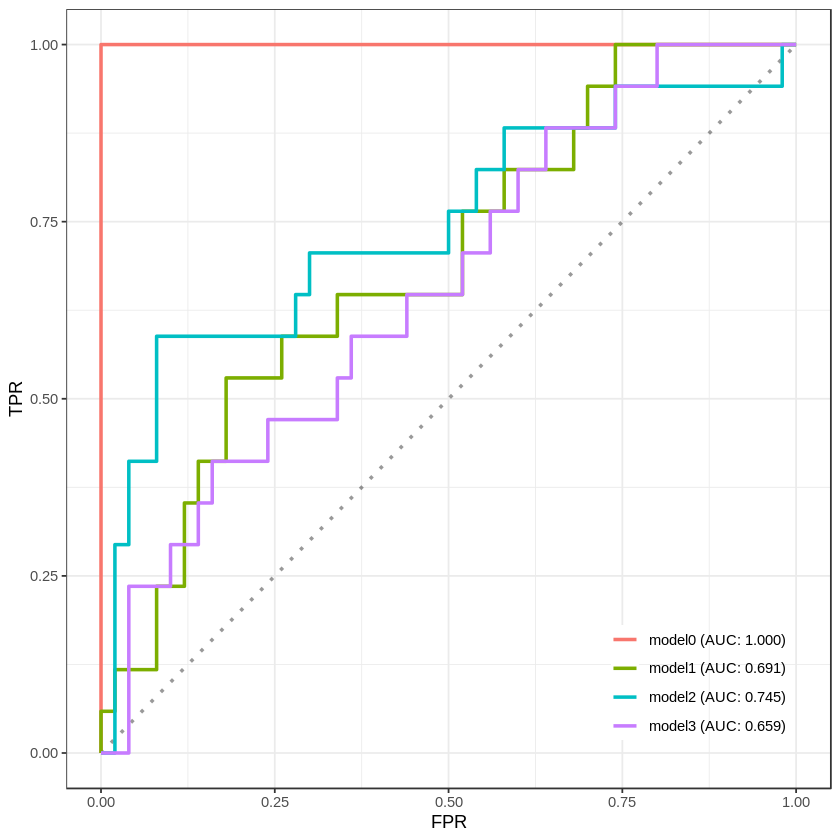

In [224]:
# All models
bhoj_models <- list(bhoj_idx0, bhoj_idx1, bhoj_idx2, bhoj_idx3)
X_pred <- sapply(bhoj_models, predict_lr)
colnames(X_pred) <- paste0("model", seq(0, 3))
Xpred_y <- data.frame(X_pred, label = bhoj_lab)

bhoj_alltrain_roc <- plot_roc(
  data.frame(Xpred_y),
  "label", paste0("model", seq(0, 3)),
  direction = "<"
)
bhoj_alltrain_roc

In [1184]:
# # Predictions using coefficients
# bhoj1 <- d0_alltrain[bhoj_idx1, ]
# beta <- c(-1.5098, -0.9255, 1.0896, -0.3423)
# y_pred <- beta[2:4] %*% data.matrix(bhoj1) + beta[1]
# p <- 1 / (1 + exp(-y_pred))

#### Train/test split

In [214]:
sid_d0_train <- sid_train4[endsWith(sid_train4, "_D0")]
sid_d0_test <- sid_test4[endsWith(sid_test4, "_D0")]
d0_train <- log_scaled_data[, sid_d0_train]
colnames(d0_train) <- substring(colnames(d0_train), 1, 4)
d0_test <- log_scaled_data[, sid_d0_test]
colnames(d0_test) <- substring(colnames(d0_test), 1, 4)

bhoj_lab_train <- as.factor(surv_annot[colnames(d0_train), "label"])
bhoj_lab_test <- as.factor(surv_annot[colnames(d0_test), "label"])

In [220]:
#' Iterates through different set of probesets
#' @param ps character of probesets
predict_lr_test <- function(ps) {
  d0_train_fltr <- d0_train[ps, ]
  d0_test_fltr <- d0_test[ps, ]
  Xy_train <- data.frame(t(d0_train_fltr), label = bhoj_lab_train)
  Xy_test <- data.frame(t(d0_test_fltr), label = bhoj_lab_test)
  
  bhoj_model <- glm(
    label ~ ., data = Xy_train,
    family = binomial(link = "logit"),
    maxit = 500
  )
  print(summary(bhoj_model))
  y_train <- predict(bhoj_model, newdata = Xy_train)
  y_test <- predict(bhoj_model, newdata = Xy_test)
  list(train = y_train, test = y_test)
}

In [232]:
# LP1
bhoj_obj <- predict_lr_test(bhoj_idx1)
bhoj_y_train <- bhoj_obj$train
bhoj_y_test <- bhoj_obj$test


Call:
glm(formula = label ~ ., family = binomial(link = "logit"), data = Xy_train, 
    maxit = 500)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2337  -0.8067  -0.5070  -0.2389   2.3489  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)   18.1008    14.0410   1.289   0.1974  
X201472_at    -1.8286     0.9348  -1.956   0.0504 .
X208687_x_at   0.7689     0.5523   1.392   0.1639  
X212576_at    -0.8844     0.6545  -1.351   0.1766  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 60.687  on 55  degrees of freedom
Residual deviance: 53.802  on 52  degrees of freedom
AIC: 61.802

Number of Fisher Scoring iterations: 5



In [228]:
# Multiple bhoj models
bhoj_models <- list(bhoj_idx0, bhoj_idx1, bhoj_idx2, bhoj_idx3)
y_train_test <- lapply(bhoj_models, predict_lr_test)

# Train set
bhoj_y_train <- sapply(y_train_test, function(obj) obj$train)
colnames(bhoj_y_train) <- paste0("model", seq(0, 3))
bhoj_y_label_train <- data.frame(bhoj_y_train, label = bhoj_lab_train)
bhoj_train_roc <- plot_roc(
  bhoj_y_label_train, "label",
  paste0("model", seq(0, 3)),
  direction = "<"
)
# Test set
bhoj_y_test <- sapply(y_train_test, function(obj) obj$test)
colnames(bhoj_y_test) <- paste0("model", seq(0, 3))
bhoj_y_label_test <- data.frame(bhoj_y_test, label = bhoj_lab_test)
bhoj_test_roc <- plot_roc(
  bhoj_y_label_test, "label",
  paste0("model", seq(0, 3)),
  direction = "<"
)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = label ~ ., family = binomial(link = "logit"), data = Xy_train, 
    maxit = 500)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-6.075e-06  -2.161e-06  -2.110e-08  -2.110e-08   5.354e-06  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)   3.311e+02  1.778e+07       0        1
X35666_at    -3.280e+00  7.180e+04       0        1
X205401_at    5.846e+00  2.459e+05       0        1
X208687_x_at -3.832e+01  1.414e+06       0        1
X212229_s_at -1.582e+01  1.138e+06       0        1
X212576_at    1.988e+00  1.105e+06       0        1
X221840_at   -1.110e+01  2.297e+05       0        1
X203514_at    1.027e+01  2.959e+05       0        1
X217499_x_at -1.530e+01  7.663e+05       0        1
X221891_x_at  2.028e+01  1.735e+06       0        1
X201642_at   -5.747e+00  1.449e+05       0        1
X218418_s_at  5.117e+00  9.643e+04       0        1
X216035_x_at  2.230e+01  3.891e+05       0        1
X208820_at 

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 4
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:57] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:57] 0 0.0233 0.0465 0.0698 0.093 ...
  ..$ thresholds        : num [1:57] -Inf -121.5 -105 -96.3 -84.3 ...
  ..$ direction         : chr "<"
  ..$ cases             : num [1:13] 25.9 25.8 27.9 25 27.1 ...
  ..$ controls          : num [1:43] -101.7 -37.7 -26.1 -27.2 -27.4 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 1
  .. ..- attr(*, "partial.auc")= logi FALSE
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:57] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:57] 0 0.0233 0.0465 0.0698 0.093 ...
  .. .. ..$ thresholds        : num [1:57] -Inf -121.5 -105 -96.3 -84.3 ...
  .. .. ..$ direction         : chr "<"
  .. .. ..$ cases             :

Warning message:
“Ignoring unknown parameters: direction”Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 4
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:22] 1 1 0.857 0.857 0.857 ...
  ..$ specificities     : num [1:22] 0 0.0714 0.0714 0.1429 0.2143 ...
  ..$ thresholds        : num [1:22] -Inf -85.1 -76.9 -70.2 -65.8 ...
  ..$ direction         : chr "<"
  ..$ cases             : num [1:7] -10.5 -81.4 -37.6 88.3 8.9 ...
  ..$ controls          : num [1:14] -58.9 -68 -51.1 -72.5 -88.9 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.663
  .. ..- attr(*, "partial.auc")= logi FALSE
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:22] 1 1 0.857 0.857 0.857 ...
  .. .. ..$ specificities     : num [1:22] 0 0.0714 0.0714 0.1429 0.2143 ...
  .. .. ..$ thresholds        : num [1:22] -Inf -85.1 -76.9 -70.2 -65.8 ...
  .. .. ..$ direction         : chr "<"
  .. .. ..$ cases    

Warning message:
“Ignoring unknown parameters: direction”Coordinate system already present. Adding new coordinate system, which will replace the existing one.


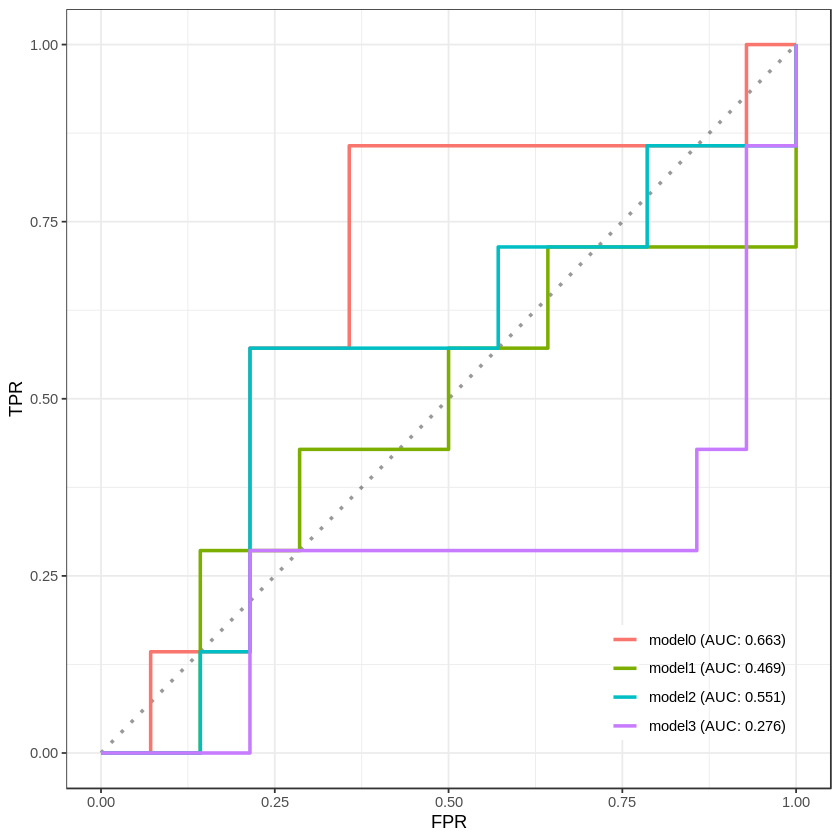

In [230]:
bhoj_test_roc

#### Example: Iris data set

In [1094]:
iris_sub <- iris[iris$Species != "versicolor", ]
iris_sub$Species <- droplevels(iris_sub$Species)
iris_pca <- prcomp(iris_sub[, 1:4])$x
iris_pca1 <- data.frame(
  iris_pca[, 1:2],
  label = iris_sub$Species
)

In [1129]:
iris_model <- glm(label ~ ., data = iris_pca1,
                  family = binomial(link = "logit"), maxit = 500)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

## Finding classification threshold

In [436]:
# Calculate threshold that maximises recall and specificity
# for global ERM predictions
#' @param X_train dataframe of global ERM features of training set
#' @param X_test dataframe of global ERM features of test set
#' @param metadata dataframe of metadata with pid as rownames (yeoh_label)
argmax_threshold <- function(X_train, metadata) {
  X_train_y <- data.frame(
    X_train,
    label = metadata[rownames(X_train), "label"]
  )

  roc_obj <- pROC::roc(X_train_y, "label", "erm1", direction = ">")
  # NOTE: roc function calculates thresholds by taking the 
  # arithmetic mean of two adjacent points
  roc_thresholds <- data.frame(
    roc_obj$thresholds,
    roc_obj$sensitivities,
    roc_obj$specificities
  )
  roc_thresholds$mean <- mapply(
    function(x, y) mean(c(x, y)),
    roc_obj$sensitivities,
    roc_obj$specificities
  )

  threshold <- roc_thresholds[
    which.max(roc_thresholds$mean), "roc_obj.thresholds"
  ]
  
  threshold
}

#' @return dataframe of original test set features concatenated with
#' predictions based on threshold
predict_test <- function(X_test, threshold, metadata) {
  data.frame(
    X_test,
    label = metadata[rownames(X_test), "label"],
    y_pred = ifelse(X_test$erm1 < threshold, 1, 0)
  )  
}

threshold <- argmax_threshold(global_erm_train1, yeoh_label)
global_erm_test1_all <- predict_test(global_erm_test1, threshold, yeoh_label)
recall <- calc_recall(global_erm_test1_all$label, global_erm_test1_all$y_pred)
specificity <- calc_specificity(global_erm_test1_all$label, global_erm_test1_all$y_pred)

Setting levels: control = 0, case = 1


[1] 53.4722
[1] 0.875
[1] 0.4683544


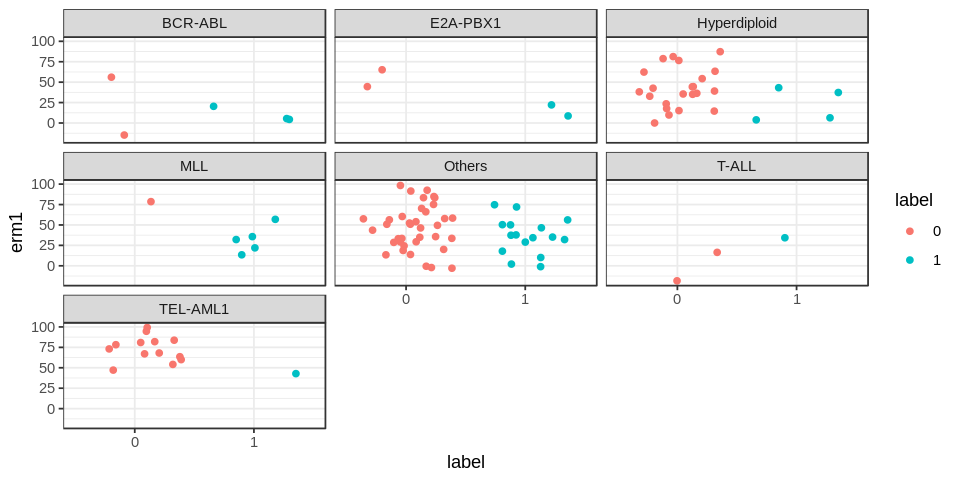

In [441]:
print(threshold)
print(recall)
print(specificity)
global_erm_test1_all2 <- global_erm_test1_all
global_erm_test1_all2$label <- as.factor(global_erm_test1_all2$label)
global_erm_test1_all2$subtype <- yeoh_label[
  rownames(global_erm_test1_all2), "subtype"
]

ggplot(global_erm_test1_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [378]:
# Calculate threshold that maximises recall and specificity
# class(yeoh_label[rownames(global_erm_train2), "label"])
global_erm_train2_y <- data.frame(
  global_erm_train2,
  label = yeoh_label[rownames(global_erm_train2), "label"]
)

roc_obj <- pROC::roc(
  global_erm_train2_y,
  "label",
  "erm1",
  direction = ">"
)
# NOTE: roc function calculates thresholds by taking the 
# arithmetic mean of two adjacent points
roc_thresholds <- data.frame(
  roc_obj$thresholds,
  roc_obj$sensitivities,
  roc_obj$specificities
)
roc_thresholds$mean <- mapply(
  function(x, y) mean(c(x, y)),
  roc_obj$sensitivities,
  roc_obj$specificities
)

Setting levels: control = 0, case = 1


In [395]:
threshold <- roc_thresholds[which.max(roc_thresholds$mean), "roc_obj.thresholds"]

global_erm_test2_all <- data.frame(
  global_erm_test2,
  label = yeoh_label[rownames(global_erm_test2), "label"],
  y_pred = ifelse(global_erm_test2$erm1 < threshold, 1, 0)
)

global_erm_test2_recall <- calc_recall(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
global_erm_test2_specificity <- calc_specificity(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
print(global_erm_test2_recall)
print(global_erm_test2_specificity)

[1] 0.9166667
[1] 0.8


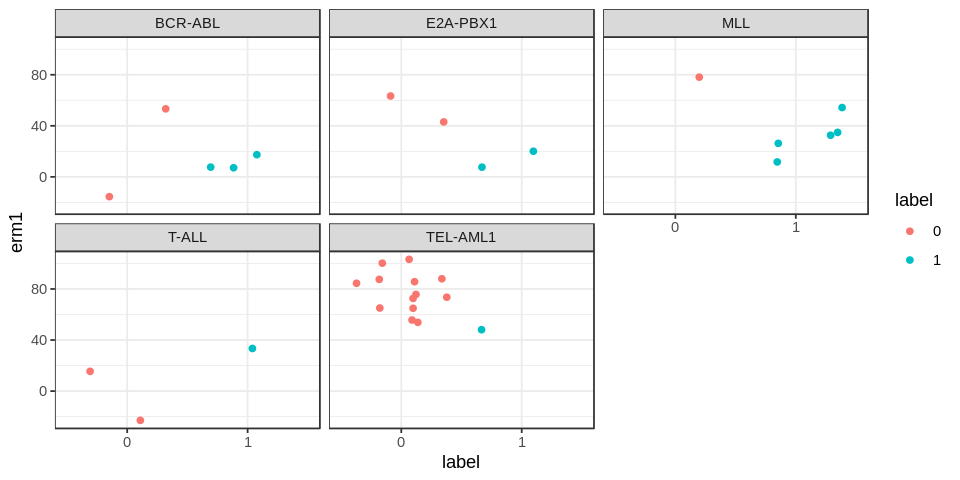

In [443]:
global_erm_test2_all2 <- global_erm_test2_all
global_erm_test2_all2$label <- as.factor(global_erm_test2_all2$label)
global_erm_test2_all2$subtype <- yeoh_label[
  rownames(global_erm_test2_all2), "subtype"
]

ggplot(global_erm_test2_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [282]:
a <- plot_roc(
  aSAH,
  "outcome",
  c("s100b", "ndka"),
  pauc.limits = c(1, 0.6),
  pauc.axis = "sensitivity"
)

Setting levels: control = Good, case = Poor
Setting direction: controls < cases
Setting levels: control = Good, case = Poor
Setting direction: controls < cases


[1] "ndka (0.561)"  "s100b (0.642)"


### Plot: Jitter

### Training data (w Hyper, Others)

In [93]:
X_normal <- data[, rownames(Y)[Y$class_info == "N"]]
list_X_subtype1 <- lapply(
  subtypes,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj1 <- lapply(
  list_X_subtype1,
  predict_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of selected genes = " "80"                      
[1] "No. of final genes = " "66"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [526]:
# #' Plots boxplot of features, p_rem and global ERM
# #' Provides p-values of log(mrd), p_rem and global ERM
# plot_boxplots1 <- function(X_y) {
#   COL_LABEL <- c("darkolivegreen3", "tomato3")
#   FEAT_ORDER <- c(
#     "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
#     "log_mrd", "global_erm", "p_rem"
#   )
#   FEAT_LABS <- c(
#     "'ERM Ratio'", "'ARM Ratio'", "theta",
#     "log[10](MRD)", "'Global ERM'", "paste('P(Remission|', bold(x), ')')"
#   )
  
#   long_X_y <- melt(X_y, id = "label", variable.name = "feature")

#   # Reorder levels and label features
#   long_X_y$feature <- factor(
#     long_X_y$feature,
#     levels = FEAT_ORDER,
#     labels = FEAT_LABS
#   )
  
#   ax_jitter <- ggplot(
#     long_X_y,
#     aes(x = feature, y = value, colour = label)
#   ) +
#     geom_boxplot(alpha = 0, show.legend = F) +
#     geom_point(
#       position = position_jitterdodge(),
#       cex = 2, # pch = 21, colour = "black",
#       show.legend = F
#     ) +
#     scale_colour_manual(values = COL_LABEL) +
#     facet_wrap(
#       ~feature,
#       nrow = 1, scales = "free",
#       labeller = label_parsed
#     ) +
#     theme(
#       axis.title.x = element_blank(),
#       axis.text.x = element_blank(),
#       axis.ticks.x = element_blank(),
#       axis.title.y = element_blank(),
#       legend.position = "none"
#     )
  
#   # Jitter plot: p-value label
#   # Both group sizes must be > 1
#   if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
#     p_labs <- sapply(
#       FEAT_ORDER,
#       function(idx) {
#         list_feat <- split(X_y[, idx], X_y$label)
#         tryCatch(
#           {
#             htest <- ks.test(list_feat[[1]], list_feat[[2]])
#             sprintf("p = %.3f", htest$p.value)
#           },
#           error = function(err) {
#             print(err)
#             return(err)
#           }
#         )
#       }
#     )
    
#     ann_text <- data.frame(
#       feature = factor(
#         FEAT_ORDER,
#         levels = FEAT_ORDER,
#         labels = FEAT_LABS
#       ),
#       value = c(
#         max(X_y[FEAT_ORDER[1]]),
#         max(X_y[FEAT_ORDER[2]]),
#         min(X_y[FEAT_ORDER[3]]),        
#         min(X_y[FEAT_ORDER[4]]),
#         max(X_y[FEAT_ORDER[5]]),
#         max(X_y[FEAT_ORDER[6]])
#       ),
#       lab = p_labs
#     )
#     ann_text <- na.omit(ann_text)

#     ax_jitter <- ax_jitter +
#       geom_label(data = ann_text,
#                   aes(x = feature, y = value, label = lab),
#                   size = 3, colour = "black",
#                   alpha = 0.5, hjust = 0)
#   }
  
#   ax_jitter
# }

### Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


### Breakdown of train and test sets

In [960]:
## Breakdown of train and test sets
idx1 <- Y$batch_info %in% 1:5 & Y$class_info == "D0"
idx2 <- !(Y$batch_info %in% 1:5) & Y$class_info == "D0"
Y_train <- Y[idx1,]
Y_test <- Y[idx2,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(xtable(tab_test))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Thu Nov 12 01:34:19 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   2 &   3 \\ 
  E2A-PBX1 &   2 &   2 \\ 
  Hyperdiploid &  22 &   4 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   5 \\ 
  Normal &   0 &   0 \\ 
  Others &  37 &  16 \\ 
  T-ALL &   2 &   1 \\ 
  TEL-AML1 &  13 &   1 \\ 
   \hline
\end{tabular}
\end{table}


#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


#### Plot x v.s. TPR

In [ ]:
plot_tpr1 <- function(x, name, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  plot(TPR, sort_x, ylab = name, col = col, type = "l")
}


plot_tpr2 <- function(x, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  lines(TPR, sort_x, col = col, type = "l")
}

cols <- ggplot_palette(4)
features <- c("ERM", "p", "p (w/o MRD)", "-log10(MRD)")

pdf("~/Dropbox/temp/tpr_x.pdf", 6, 6)
plot_tpr1(normaliseMinmax(p_y_sub$erm1), "x", cols[1])
plot_tpr2(p_y_sub$p, cols[2])
plot_tpr2(p_y_sub$p_wo, cols[3])
plot_tpr2(normaliseMinmax(-log10(p_y_sub$d33_mrd)), cols[4])
legend("topleft", legend = features, col = cols, lwd=2)
dev.off()

### Plot odds ratio

In [12]:
plot_odds_ratio <- function(P) {
  COL_LABEL <- c("darkolivegreen3", "tomato3")
  
  odds_prior <- table(P$label)[2] / table(P$label)[1] # rel/rem
  FEATURES <- c("erm1_ratio2", "l2norm_ratio2",
                "mrd", "angle_d0d8_d0normal")
  P_REM <- P[, FEATURES]
  
  compute_odds_ratio <- function(X, odds_prior) {
    (1-X) / (X * odds_prior)
  }

  odds_ratio <- data.matrix(compute_odds_ratio(P_REM, odds_prior))
  odds_ratio[is.infinite(odds_ratio)] <-
    max(odds_ratio[!is.infinite(odds_ratio)]) * 2 # replace with max * 2
  data <- cbind(
    P[, c("pid", "label")],
    odds_ratio
  )

  long_data <- melt(data, id.vars = c("pid", "label"))
  
  ggplot(long_data, aes(x = label, y = value, colour = label)) +
    geom_point(position = position_jitter(height = 0), cex = 3) +
    facet_wrap(~variable, nrow = 1, scales = "free_x") +
    scale_color_manual(values = COL_LABEL)
}

In [520]:
list_odds_ratio <- lapply(list_obj1, function(obj) plot_odds_ratio(obj$P))
for (i in seq_along(list_odds_ratio)) {
  wpath <- sprintf("~/Dropbox/temp/OR-%s.pdf", subtypes[i])
  ggsave(wpath, list_odds_ratio[[i]], width = 8, height = 3)
}

## Subnetworks

In [8]:
# 1. Removes affymetrix ambiguous and control probesets
# 2. Map probesets to IDs
# Removes one-to-many probesets and probesets with no ID
# Selects maximum if two probesets match to same gene
# CHECK: What microarray platform is the data from?
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_data <- affy2id(data, ENTREZ_GPL570)

## SYMBOL_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
## symbol_yeoh <- affy2id(data_yeoh, SYMBOL_GPL570)

No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [572]:
# Calculate individual D0-N magnitude (normal centroid)
normal <- entrez_data[, startsWith(colnames(entrez_data), "N")]
D0 <- entrez_data[, endsWith(colnames(entrez_data), "D0")]
D8 <- entrez_data[, endsWith(colnames(entrez_data), "D8")]

#### Unfiltered data

In [573]:
raw_data <- log2_transform(selected_yeoh)
araw <- affy2id(raw_data, ENTREZ_GPL570)
lidx1 <- sapply(subnetwork_nea,
                function(ids) all(ids %in% rownames(araw)))
subnetwork2 <- subnetwork_nea[lidx1]
print(length(subnetwork2))
                
# Calculate individual D0-N magnitude (normal centroid)
normal_raw <- araw[, startsWith(colnames(araw), "N")]
D0_raw <- araw[, endsWith(colnames(araw), "D0")]
D8_raw <- araw[, endsWith(colnames(araw), "D8")]

No. of probesets mapping to multiple IDs removed: 412
No. of probesets with no ID removed: 1010
Total no. of probesets removed (incl. probesets mapping to same gene): 4185
[1] 4715


#### Import subnetworks

In [ ]:
## Import NEA subnetworks
NEA_RPATH <- paste0("../diff_expr/data/subnetwork/nea-hsa/",
                    "ovarian_cancer/geneset-nea_kegg_ovarian.tsv")
nea_df <- read.table(NEA_RPATH, sep = "\t", header = T, stringsAsFactors = F)
subnetwork_nea <- split(as.character(nea_df$gene_id), nea_df$subnetwork_id)

In [570]:
# Filter out subnetworks with genes that are missing in the data
lidx <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(entrez_data)))
nea_fltr <- subnetwork_nea[lidx]
               
lidx1 <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(araw)))
nea_unfltr <- subnetwork_nea[lidx1]

In [728]:
print(length(subnetwork_nea))
print(length(nea_unfltr))

[1] 4715
[1] 4715


#### Only half of the KEGG ids are represented in the data

In [539]:
## Import KEGG pathways
KEGG_RPATH <- "../info/KEGG/kegg-human_allpathway_genes.tsv"
kegg_df <- read.table(KEGG_RPATH, sep = "\t", header = T, stringsAsFactors = F)
kegg_df$Pathway <- substring(kegg_df$Pathway, 6)
list_kegg <- split(kegg_df$Entrez.Gene.ID, kegg_df$Pathway)

In [549]:
sum(unique(unlist(list_kegg)) %in% rownames(araw))

[1] 3839

In [551]:
# kegg_size <- sapply(subnetwork_pwapi, length)
# kegg_hit <- sapply(subnetwork_pwapi,
#                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data
incomplete_kegg <- lapply(list_kegg,
                          function(ids) ids[ids %in% rownames(araw)])
kegg_size <- sapply(incomplete_kegg, length)
SIZE <- 5
incomplete_kegg_sub <- incomplete_kegg[kegg_size > SIZE]
kegg_size1 <- sapply(incomplete_kegg_sub, length)

In [417]:
## Import pathwayAPI
PWAPI_RPATH <- "../info/pathwayAPI/pwapi_id_human-filtered_entrez.tsv"
pwapi_df <- read.table(PWAPI_RPATH, sep = "\t", header = T, stringsAsFactors = F)
list_pwapi <- split(pwapi_df[,2:3], pwapi_df$pathway_id)
subnetwork_pwapi <- lapply(list_pwapi,
                           function(X) unique(as.numeric(data.matrix(X))))

In [466]:
pwapi_size <- sapply(subnetwork_pwapi, length)
pwapi_hit <- sapply(subnetwork_pwapi,
                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data in pathwayAPI
subnetwork_pwapi_sub <- lapply(subnetwork_pwapi,
                                function(ids) ids[ids %in% rownames(araw)])
pwapi_size1 <- sapply(subnetwork_pwapi_sub, length)
SIZE <- 5
subnetwork_pwapi_sub1 <- subnetwork_pwapi_sub[pwapi_size1 > SIZE]
pwapi_size2 <- sapply(subnetwork_pwapi_sub1, length)
print(cbind(pwapi_hit[pwapi_size1 > SIZE], pwapi_size2))

             pwapi_size2
pwapi002  10          10
pwapi003 144         144
pwapi004  36          36
pwapi005  67          67
pwapi006  39          39
pwapi007  43          43
pwapi008  14          14
pwapi012   6           6
pwapi016  11          11
pwapi017  28          28
pwapi018  24          24
pwapi019  23          23
pwapi020  29          29
pwapi021  44          44
pwapi022  55          55
pwapi023   8           8
pwapi024 116         116
pwapi025  30          30
pwapi026  17          17
pwapi029  75          75
pwapi030 139         139
pwapi031  27          27
pwapi032  27          27
pwapi033  27          27
pwapi034  28          28
pwapi036  13          13
pwapi037  22          22
pwapi038  12          12
pwapi040  16          16
pwapi041  18          18
pwapi042  10          10
pwapi044  32          32
pwapi045 108         108
pwapi046  54          54
pwapi048  68          68
pwapi049  32          32
pwapi050  11          11
pwapi051  23          23
pwapi052  28          28


#### Subnetwork deltas (D0-N)
- Comparing variance of subnetwork deltas was not conclusive
- Means of the random sample seem to have a larger proportion of higher mean subnetworks

- Sum of deltas (D0-D8) is not a good feature
- Percentage of sum of deltas is not a good feature
    - Does not take into account the sign of the logfc
    - Does not consider individual subnetwork
- Percentage of each subnetwork
    - Filter out subnetwork that has delta_D0N of less than threshold?

In [571]:
#' @param ids vector of gene IDs belonging to a subnetwork
#' @param X dataframe of expr values at D0
#' @param Y vector or dataframe of expr values at specific timepoint
#' @return vector of deltas of patients of a particular subnetwork
calc_subnetwork_delta <- function(ids, X, Y) {
  if(is.numeric(ids)) # how to handle factor?
    ids <- as.character(ids)
  
  if (is.vector(Y)) {
    logfc <- Y[ids] - X[ids,]
  } else {
    stopifnot(substring(colnames(X),1,4) ==
              substring(colnames(Y),1,4))
    logfc <- Y[ids,] - X[ids,]
  }
  return(colMeans(abs(logfc)))
}

In [651]:
# Plots batches in different colours and classes in different symbols
plotPCA2D <- function(df1, metadata_df, pc_labels = NULL) {
  # Obtaining batch and class annotations
  batch_factor <- as.factor(metadata_df[colnames(df1),"label"])
  class_factor <- metadata_df[colnames(df1), "subtype"]
  print(head(batch_factor))
  print(head(class_factor))
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(df1))
    pca_df <- data.frame(pca_obj$x[,1:4])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(df1)
  }
  
  pc1_pc2 <- ggplot(pca_df, aes(x = PC1, y = PC2, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  # theme(plot.title = element_text(hjust = 0.5))

  pc1_pc3 <- ggplot(pca_df, aes(x = PC1, y = PC3, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = F) +
    labs(x = pc_labels[1], y = pc_labels[3]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)

  pca_plot <- plot_grid(pc1_pc2, pc1_pc3)
  
  return(pca_plot)
}

#### Filtered data - NEA

In [574]:
norm_centroid <- rowMeans(normal)

delta_D0N <- data.frame(t(sapply(nea_fltr,
                                 calc_subnetwork_delta,
                                 D0, norm_centroid)))
delta_D0D8 <- data.frame(t(sapply(nea_fltr,
                                  calc_subnetwork_delta,
                                  D0, D8)))

In [658]:
print(length(nea_unfltr))

[1] 4715


[1] "BCR-ABL"
[1] 9


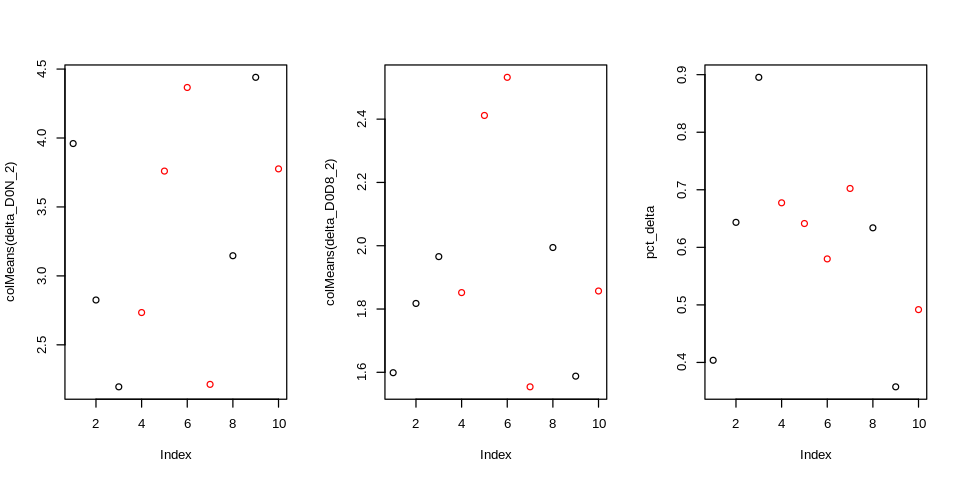

In [669]:
subtype <- subtypes[[1]]
print(subtype)
delta_D0N_1 <- delta_D0N[
  , Y[colnames(delta_D0N), "subtype"] == subtype
]
delta_D0D8_1 <- delta_D0D8[
  , Y[colnames(delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

mu_delta <- apply(delta_D0N_1, 1, mean)
var_delta <- apply(delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)

THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))
delta_D0D8_2 <- delta_D0D8_1[idx_subnetwork, ]
delta_D0N_2 <- delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- colMeans(delta_D0D8_2) / colMeans(delta_D0N_2)

par(mfrow=c(1,3))
plot(colMeans(delta_D0N_2), col = Y[names(pct_delta), "label"] + 1)
plot(colMeans(delta_D0D8_2), col = Y[names(pct_delta), "label"] + 1)
plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

In [662]:
print(colnames(delta_D0D8_1)[Y[colnames(delta_D0D8_1), "label"] == 1])

[1] "P056_D8" "P057_D8" "P134_D8" "P152_D8" "P184_D8"


[1] 0 0 0 0 0 0
Levels: 0 1
[1] TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1
9 Levels: BCR-ABL E2A-PBX1 Hyperdiploid Hypodiploid MLL Normal ... TEL-AML1


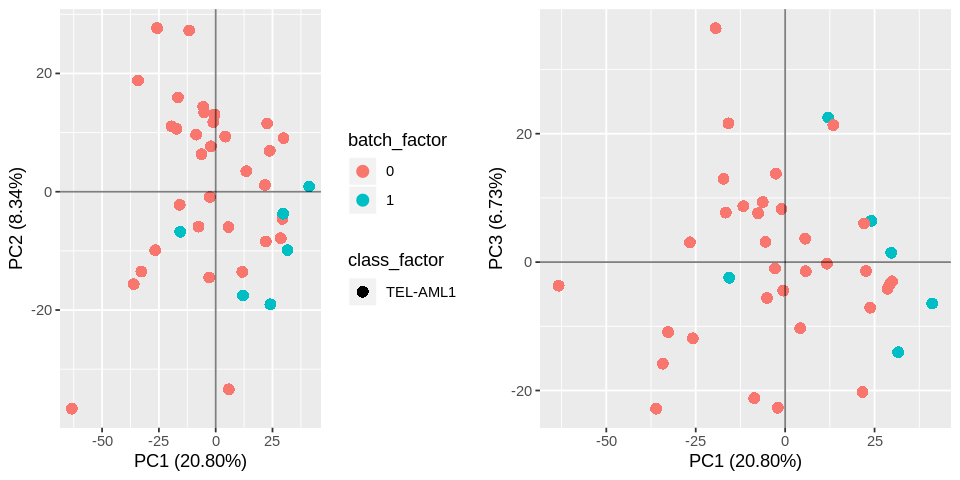

In [653]:
plotPCA2D(raw_delta_D0D8_1, Y)

#### Unfiltered data - NEA

In [641]:
norm_centroid1 <- rowMeans(normal_raw)

raw_delta_D0N <- data.frame(t(sapply(nea_unfltr,
                                 calc_subnetwork_delta,
                                 D0_raw, norm_centroid1)))
raw_delta_D0D8 <- data.frame(t(sapply(nea_unfltr,
                                  calc_subnetwork_delta,
                                  D0_raw, D8_raw)))

In [734]:
for (subtype in subtypes) {
  print(subtype)
  raw_delta_D0N_1 <- raw_delta_D0N[
    , Y[colnames(raw_delta_D0N), "subtype"] == subtype
  ]
  raw_delta_D0D8_1 <- raw_delta_D0D8[
    , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
  ]

  stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
            substring(colnames(raw_delta_D0D8_1),1,4))

  mu_delta <- apply(raw_delta_D0N_1, 1, mean)
  var_delta <- apply(raw_delta_D0N_1, 1, var)
  # plot(mu_delta, var_delta)
  THRESHOLD <- 3
  idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]

  ## Selecting subnetworks with significant dysregulation
  raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
  raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

  # print(colnames(delta_D0D8_1)[
  #   Y[colnames(delta_D0D8_1), "label"] == 1
  # ])

  pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
  
  #   pct_delta_rem <- pct_delta[, Y[colnames(pct_delta), "label"] == 0]
#   mean_pct <- rowMeans(pct_delta_rem)
#   PCT <- 0.7
#   nea_responsive <- names(mean_pct)[mean_pct > PCT]
#   print(length(nea_responsive))
#   pct_delta_responsive <- colMeans(pct_delta[nea_responsive, ])

  fpath <- sprintf("~/Dropbox/temp/delta-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(raw_delta_D0N_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0N)",
       pch = 16, cex = 1.5)
  plot(colMeans(raw_delta_D0D8_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0D8)",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(pct_delta)",
       pch = 16, cex = 1.5)
#   plot(pct_delta_responsive,
#        col = Y[names(pct_delta), "label"] + 1,
#        ylab = "mean_responsive(pct_delta)")
  dev.off()
  
  ## Relapse prediction
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  feat <- predict_relapse(pid_subtype, data, pid_remission, Y,
                          batch_genes = batch_genes)  
  
  fpath <- sprintf("~/Dropbox/temp/delta_corr-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(pct_delta), feat[, "erm1_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "erm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "l2norm_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "l2norm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "angle_d0d8_normal"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "angle_d0d8_normal",
       pch = 16, cex = 1.5)
  dev.off()
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1

In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


#### Unfiltered data - PathwayAPI

In [484]:
norm_centroid1 <- rowMeans(normal_raw)

pwapi_delta_D0N <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
pwapi_delta_D0D8 <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [535]:
subtype <- subtypes[[4]]
print(subtype)
pwapi_delta_D0N_1 <- pwapi_delta_D0N[
  , Y[colnames(pwapi_delta_D0N), "subtype"] == subtype
]
pwapi_delta_D0D8_1 <- pwapi_delta_D0D8[
  , Y[colnames(pwapi_delta_D0D8), "subtype"] == subtype
]

[1] "MLL"


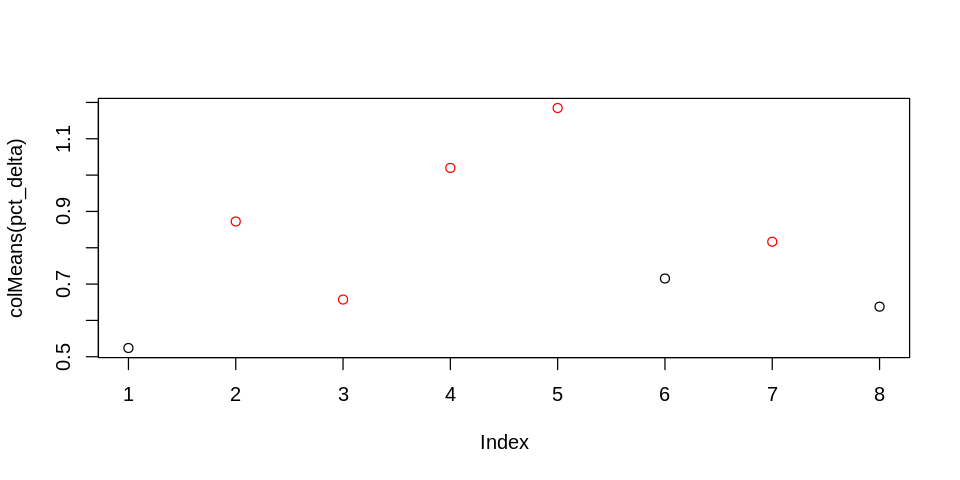

In [536]:
stopifnot(substring(colnames(pwapi_delta_D0N_1),1,4) ==
          substring(colnames(pwapi_delta_D0D8_1),1,4))

pwapi_mu_delta <- apply(pwapi_delta_D0N_1, 1, mean)
pwapi_var_delta <- apply(pwapi_delta_D0N_1, 1, var)
# plot(pwapi_mu_delta, pwapi_var_delta)

THRESHOLD <- 2.5
idx_subnetwork3 <- names(pwapi_mu_delta)[pwapi_mu_delta > THRESHOLD]
pwapi_delta_D0D8_2 <- pwapi_delta_D0D8_1[idx_subnetwork3, ]
pwapi_delta_D0N_2 <- pwapi_delta_D0N_1[idx_subnetwork3, ]

# print(colnames(pwapi_delta_D0D8_1)[
#   Y[colnames(pwapi_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- pwapi_delta_D0D8_2 / pwapi_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Unfiltered data - KEGG

In [552]:
norm_centroid1 <- rowMeans(normal_raw)

kegg_delta_D0N <- data.frame(t(sapply(incomplete_kegg_sub,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
kegg_delta_D0D8 <- data.frame(t(sapply(incomplete_kegg_sub,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [566]:
subtype <- subtypes[[7]]
print(subtype)
kegg_delta_D0N_1 <- kegg_delta_D0N[
  , Y[colnames(kegg_delta_D0N), "subtype"] == subtype
]
kegg_delta_D0D8_1 <- kegg_delta_D0D8[
  , Y[colnames(kegg_delta_D0D8), "subtype"] == subtype
]

[1] "TEL-AML1"


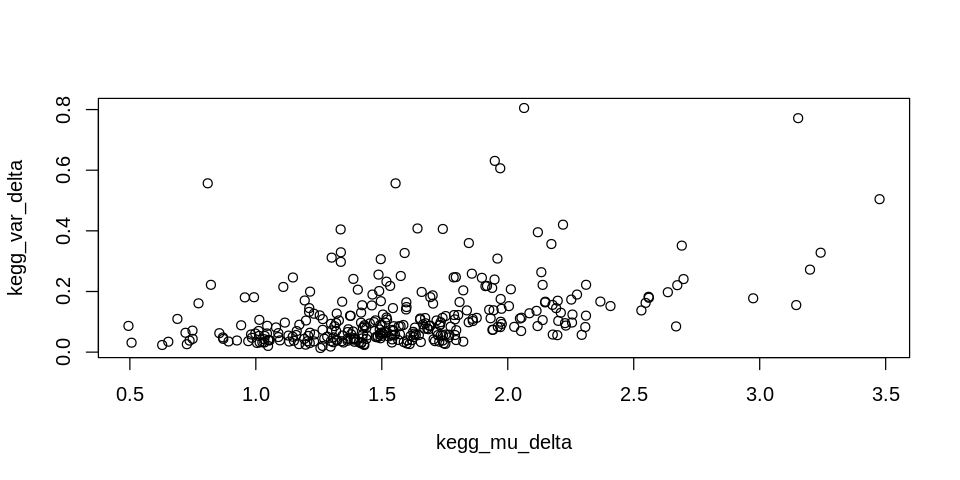

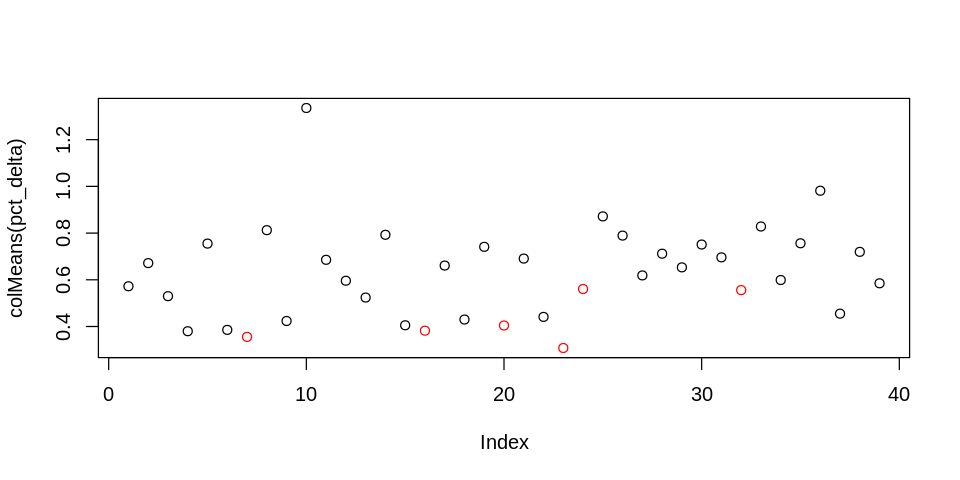

In [567]:
stopifnot(substring(colnames(kegg_delta_D0N_1),1,4) ==
          substring(colnames(kegg_delta_D0D8_1),1,4))

kegg_mu_delta <- apply(kegg_delta_D0N_1, 1, mean)
kegg_var_delta <- apply(kegg_delta_D0N_1, 1, var)
plot(kegg_mu_delta, kegg_var_delta)

THRESHOLD <- 2
idx_subnetwork4 <- names(kegg_mu_delta)[kegg_mu_delta > THRESHOLD]
kegg_delta_D0D8_2 <- kegg_delta_D0D8_1[idx_subnetwork4, ]
kegg_delta_D0N_2 <- kegg_delta_D0N_1[idx_subnetwork4, ]

# print(colnames(kegg_delta_D0D8_1)[
#   Y[colnames(kegg_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- kegg_delta_D0D8_2 / kegg_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Misc

In [49]:
## Distribution of subnetwork sizes
subnetwork_sizes <- sapply(subnetwork_nea, length)
print(table(subnetwork_sizes))

## Representation of gene IDs in data
all_ids <- unlist(subnetwork_nea)
print(head(sort(names(table(all_ids)))))
print(head(sort(rownames(entrez_data))))

[1] "10"        "100"       "10000"     "10010"     "100131827" "10014"    
[1] "100"       "10000"     "10001"     "10005"     "10010"     "100127972"


#### Data
- 405 samples (201 D0, 201 D8,3 N)
- Originally 210 patients
- Removed 2 outliers, 7 different batches

In [747]:
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")

[1] "P001_D0"  "P004_D0"  "P005_D0"  "P007_D0"  "P008_D0"  "P009_D0" 
  [7] "P010_D0"  "P011_D0"  "P012_D0"  "P013_D0"  "P014_D0"  "P015_D0" 
 [13] "P016_D0"  "P017_D0"  "P018_D0"  "P019_D0"  "P020_D0"  "P022_D0" 
 [19] "P023_D0"  "P024_D0"  "P025_D0"  "P026_D0"  "P027_D0"  "P028_D0" 
 [25] "P029_D0"  "P031_D0"  "P032_D0"  "P033_D0"  "P034_D0"  "P035_D0" 
 [31] "P036_D0"  "P037_D0"  "P038_D0"  "P039_D0"  "P040_D0"  "P041_D0" 
 [37] "P042_D0"  "P043_D0"  "P044_D0"  "P046_D0"  "P047_D0"  "P048_D0" 
 [43] "P049_D0"  "P050_D0"  "P051_D0"  "P053_D0"  "P054_D0"  "P055_D0" 
 [49] "P056_D0"  "P057_D0"  "P058_D0"  "P059_D0"  "P060_D0"  "P061_D0" 
 [55] "P062_D0"  "P063_D0"  "P064_D0"  "P065_D0"  "P066_D0"  "P067_D0" 
 [61] "P068_D0"  "P070_D0"  "P071_D0"  "P072_D0"  "P073_D0"  "P075_D0" 
 [67] "P076_D0"  "P077_D0"  "P078_D0"  "P080_D0"  "P081_D0"  "P082_D0" 
 [73] "P083_D0"  "P084_D0"  "P085_D0"  "P086_D0"  "P087_D0"  "P088_D0" 
 [79] "P089_D0"  "P090_D0"  "P091_D0"  "P092_D0"  "P093_D0"  "P094_D0" 
 [85] "P095_D0"  "P096_D0"  "P097_D0"  "P098_D0"  "P099_D0"  "P100_D0" 
 [91] "P101_D0"  "P102_D0"  "P103_D0"  "P104_D0"  "P105_D0"  "P106_D0" 
 [97] "P107_D0"  "P108_D0"  "P109_D0"  "P110_D0"  "P111_D0"  "P112_D0" 
[103] "P113_D0"  "P114_D0"  "P115_D0"  "P116_D0"  "P117_D0"  "P118_D0" 
[109] "P119_D0"  "P120_D0"  "P121_D0"  "P122_D0"  "P123_D0"  "P124_D0" 
[115] "P125_D0"  "P126_D0"  "P127_D0"  "P128_D0"  "P129_D0"  "P130_D0" 
[121] "P131_D0"  "P132_D0"  "P133_D0"  "P134_D0"  "P135_D0"  "P136_D0" 
[127] "P137_D0"  "P138_D0"  "P139_D0"  "P140_D0"  "P141_D0"  "P142_D0" 
[133] "P143_D0"  "P144_D0"  "P145_D0"  "P146_D0"  "P147_D0"  "P148_D0" 
[139] "P149_D0"  "P150_D0"  "P151_D0"  "P152_D0"  "P153_D0"  "P154_D0" 
[145] "P155_D0"  "P156_D0"  "P157_D0"  "P158_D0"  "P159_D0"  "P160_D0" 
[151] "P161_D0"  "P162_D0"  "P163_D0"  "P164_D0"  "P165_D0"  "P166_D0" 
[157] "P167_D0"  "P168_D0"  "P169_D0"  "P170_D0"  "P171_D0"  "P172_D0" 
[163] "P173_D0"  "P174_D0"  "P175_D0"  "P176_D0"  "P177_D0"  "P178_D0" 
[169] "P179_D0"  "P180_D0"  "P181_D0"  "P182_D0"  "P183_D0"  "P184_D0" 
[175] "P185_D0"  "P187_D0"  "P188_D0"  "P189_D0"  "P190_D0"  "P191_D0" 
[181] "P192_D0"  "P193_D0"  "P194_D0"  "P195_D0"  "P196_D0"  "P197_D0" 
[187] "P199_D0"  "P200_D0"  "P201_D0"  "P202_D0"  "P203_D0"  "P204_D0" 
[193] "P205_D0"  "P206_D0"  "P207_D0"  "P208_D0"  "P209_D0"  "P210_D0" 
[199] "P211_D0"  "P212_D0"  "P213_D0"  "P214_D0"  "P215_D0"  "P216_D0" 
[205] "P217_D0"  "P218_D0"  "P219_D0"  "P220_D0"  "P001_D8"  "P004_D8" 
[211] "P005_D8"  "P007_D8"  "P008_D8"  "P009_D8"  "P010_D8"  "P011_D8" 
[217] "P012_D8"  "P013_D8"  "P014_D8"  "P015_D8"  "P016_D8"  "P017_D8" 
[223] "P018_D8"  "P019_D8"  "P020_D8"  "P022_D8"  "P023_D8"  "P024_D8" 
[229] "P025_D8"  "P026_D8"  "P027_D8"  "P028_D8"  "P029_D8"  "P031_D8" 
[235] "P032_D8"  "P033_D8"  "P034_D8"  "P035_D8"  "P036_D8"  "P037_D8" 
[241] "P038_D8"  "P039_D8"  "P040_D8"  "P041_D8"  "P042_D8"  "P043_D8" 
[247] "P044_D8"  "P046_D8"  "P047_D8"  "P048_D8"  "P049_D8"  "P050_D8" 
[253] "P051_D8"  "P053_D8"  "P054_D8"  "P055_D8"  "P056_D8"  "P057_D8" 
[259] "P058_D8"  "P059_D8"  "P060_D8"  "P061_D8"  "P062_D8"  "P063_D8" 
[265] "P064_D8"  "P065_D8"  "P066_D8"  "P067_D8"  "P068_D8"  "P070_D8" 
[271] "P071_D8"  "P072_D8"  "P073_D8"  "P075_D8"  "P076_D8"  "P077_D8" 
[277] "P078_D8"  "P080_D8"  "P081_D8"  "P082_D8"  "P083_D8"  "P084_D8" 
[283] "P085_D8"  "P086_D8"  "P087_D8"  "P088_D8"  "P089_D8"  "P090_D8" 
[289] "P091_D8"  "P092_D8"  "P093_D8"  "P094_D8"  "P095_D8"  "P096_D8" 
[295] "P097_D8"  "P098_D8"  "P099_D8"  "P100_D8"  "P101_D8"  "P102_D8" 
[301] "P103_D8"  "P104_D8"  "P105_D8"  "P106_D8"  "P107_D8"  "P108_D8" 
[307] "P109_D8"  "P110_D8"  "P111_D8"  "P112_D8"  "P113_D8"  "P114_D8" 
[313] "P115_D8"  "P116_D8"  "P117_D8"  "P118_D8"  "P119_D8"  "P120_D8" 
[319] "P121_D8"  "P122_D8"  "P123_D8"  "P124_D8"  "P125_D8"  "P126_D8" 
[325] "P127_D8"  "P128_D8"  "P129_D8"  "P130_D8"  "P131_D8"  "P132_D8" 
[331] "P133_D8"  "P134_D8"  "P135_D8"  "P1

In [303]:
subtypes2 <- c("Hyperdiploid", "Others")
tab1 <- yeoh_label[yeoh_label$subtype %in% subtypes1, c("d33_mrd_risk", "label")]
tab1[tab1$d33_mrd_risk != "Standard",]

,d33_mrd_risk,label
,<fct>,<int>
P001,Intermediate,0
P004,High,0
P007,Intermediate,1
P009,Unknown,0
P011,Unknown,0
P012,Intermediate,0
P015,Intermediate,0
P019,Intermediate,1
P020,Unknown,0
